# TF_IDF SE Subtracks

In [57]:
import numpy as np
np.random.seed(2342347823)

import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as shc
import matplotlib.pylab as plt
plt.style.use("ggplot") 

from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import hamming_loss

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
import json

import sys
sys.setrecursionlimit(10000)

import data_helpers
from data_helpers import *
import imp
imp.reload(data_helpers)

<module 'data_helpers' from '/Users/kyrylo/Projects/personal/thesis/data_helpers.py'>

In [58]:
df_se_skills = pd.read_csv(PREPROCESSED_SE_SKILLS_PATH)
df_se_subtracks = pd.read_csv(PREPROCESSED_SE_TRACKS_PATH)

se_skill_names = list(df_se_skills[SKILL_TAG_LABEL])
skill_names = list_mask(df_se_subtracks.columns.to_list(), se_skill_names)
print('Total skills count:', len(skill_names))

track_names = list_mask(skill_names, list(df_se_skills[df_se_skills[IS_TRACK_NAME_LABEL] == True][SKILL_TAG_LABEL]))
skill_names = list_filter(skill_names, track_names)
country_columns = ['COUNTRY_DE','COUNTRY_EE','COUNTRY_FI','COUNTRY_LT','COUNTRY_LV','COUNTRY_PK']
be_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_BE_LABEL] == True].to_list()
fe_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_FE_LABEL] == True].to_list()

for skill in skill_names:
    df_se_subtracks[skill] = np.where(df_se_subtracks[skill] > 0, 1 , 0)

df_se_subtracks

Total skills count: 133


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

## Drop profiles with low # of skills

In [59]:
print('Dropped', df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) <= 2].shape[0])

df_se_subtracks = df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) > 2]
df_se_subtracks

Dropped 2737


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

### Drop minor classes

In [60]:
minor_cluster_names = df_se_subtracks[CLUSTER_LABEL].value_counts().to_frame().query('CLUSTER  < 10').index
rows_from_minro_clasters = df_se_subtracks[CLUSTER_LABEL].isin(minor_cluster_names).to_frame().query('CLUSTER  == True').index

print('Dropped rows:', rows_from_minro_clasters.shape)

df_se_subtracks.drop(rows_from_minro_clasters, inplace=True)
df_se_subtracks.reset_index(drop=True, inplace=True)

df_se_subtracks

Dropped rows: (12834,)


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      39108e16d196f7de86bb7c05     0   1.000000   
...                         ...   ...        ...   
25271  dd41b1210012296e07987fc5     1   1.000000   
25272  6f28bd2100c4c70e6f99cf15     1   1.000000   
25273  de11cc210041983e4a997f35     1   1.000000   
25274  dc00042100a3628f746d5f65     1   1.000000   
25275  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                   Senior iOS Developer           0   
...                                                  ...         ...   
25271                    Senior/Lead Mobile SW developer           0   
25272  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
25273  Experienced Software Developer (Backend/Fronte...           0   
25274                    Fullstack developer (part-time)           0   
25275        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
25271           0           1           0           0           0  ...   
25272           0           1           0           0           0  ...   
25273           0           1           0           0           0  ...   
25274           1           0           0           0           0  ...   
25275           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     1   
...                                 ...   
25271                                 0   
25272                                 0   
25273                                 0   
25274                                 0   
25275                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
25271                                         0   
25272                                         0   
25273                                         0   
25274                                         0   
25275                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

### Group by subtracks

In [7]:
df_for_tfidf = df_se_subtracks[[ *track_names, *skill_names, CLUSTER_LABEL]]
df_for_tfidf = df_for_tfidf.groupby(CLUSTER_LABEL).sum()
df_for_tfidf.reset_index(drop=True, inplace=True)

df_for_tfidf

software_engineering__backend_development  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                         15.0   
4                                         27.0   
..                                         ...   
654                                       11.0   
655                                       10.0   
656                                       13.0   
657                                       13.0   
658                                        0.0   

     software_engineering__data_engineering  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
654                                    11.0   
655                                    10.0   
656                                    13.0   
657                                    13.0   
658                                    13.0   

     software_engineering__database_administration  \
0                                              0.0   
1                                              0.0   
2                                             11.0   
3                                              0.0   
4                                              0.0   
..                                             ...   
654                                            0.0   
655                                            0.0   
656                                            0.0   
657                                            0.0   
658                                            0.0   

     software_engineering__devops_engineering  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
654                                       0.0   
655                                       0.0   
656                                       0.0   
657                                       0.0   
658                                       0.0   

     software_engineering__embedded_engineering  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
..                                          ...   
654                                         0.0   
655                                         0.0   
656                                         0.0   
657                                         0.0   
658                                         0.0   

     software_engineering__frontend_development  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
..                                          ...   
654                                         0.0   
655                                         0.0   
656                                         0.0   
657                                         0.0   
658                                         0.0   

     software_engineering__full_stack_development  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
..                                            ...   
654 

In [61]:
X_columns = [*skill_names, *track_names]
be_skill_names = list_mask(be_skill_names, X_columns)
fe_skill_names = list_mask(fe_skill_names, X_columns)

X_train, X_val = train_test_split(df_se_subtracks[X_columns], test_size=0.3, random_state=0, stratify=df_se_subtracks['CLUSTER'])


X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

print(X_train.shape, X_val.shape)

(17693, 133) (7583, 133)


In [64]:
_X_val = pd.DataFrame(columns=X_train.columns)
_y_val = np.array([])

for skill in features_set:
    X_val_for_skill = X_val.loc[X_val[skill]>0].copy()
    X_val_for_skill[skill] = 0
    _X_val = _X_val.append(X_val_for_skill)
    
    y_val_for_skill = np.repeat(skill, X_val_for_skill.shape[0])
    _y_val = np.append(_y_val, y_val_for_skill)
    

_X_val.reset_index(drop=True, inplace=True)
X_val = _X_val.copy()
y_val = _y_val.copy()

    
print('Train:', X_train.shape, 'Val:', X_val.shape, y_val.shape)

Train: (17693, 133) Val: (42332, 133) (42332,)


### TfidfTransformer

In [51]:
TF_IDF_KEY = 'tfifd.subtracks'

def get_tf_idf(df):
    tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tf_idf_transformer.fit(df)

    tf_idf = tf_idf_transformer.transform(df)
    tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf)
    tf_idf.columns = df.columns
    return tf_idf

def reccomend_skills(skills, similarities, isList=False, n=50):
    reccomendations = similarities.loc[skills].mean().sort_values(ascending=False)
    reccomendations = reccomendations[reccomendations>0].to_frame().nlargest(n, columns=[0]).reset_index()
    reccomendations.columns = ['skill', 'score']
    reccomendations.drop(reccomendations[reccomendations['skill'].isin(skills)].index, inplace=True)
    
    if isList:
        return list(reccomendations['skill'])
    
    print('Recomendations for:', skills)
    display(reccomendations)

In [32]:
for index in range(len(X_columns)):
    skill_name = X_columns[index]
    skill_score = tf_idf_transformer.idf_[index]
    print(skill_name, skill_score)

programming_language__bash 1.5599946475724604
programming_language__c_cpp 3.7545702167371027
programming_language__clojure 3.9368917735310576
programming_language__csharp 3.0036034652883314
programming_language__dart 4.124944005033997
programming_language__elixir 2.0157762830889605
programming_language__erlang 1.962810747509048
programming_language__fsharp 3.96587931040431
programming_language__golang 4.71965111278069
programming_language__groovy 4.49650756146648
programming_language__haskell 2.8672670217362004
programming_language__html_css 3.70805020110221
programming_language__java 3.2295599579791556
programming_language__javascript 5.882801922586371
programming_language__kotlin 5.007333185232471
programming_language__lua 4.124944005033997
programming_language__matlab 3.0036034652883314
programming_language__objective_c 2.0541605260972755
programming_language__openedge_abl 1.8574502318512216
programming_language__perl 4.273364010152271
programming_language__php 1.5494404598937703
pr

## Skills similarities 

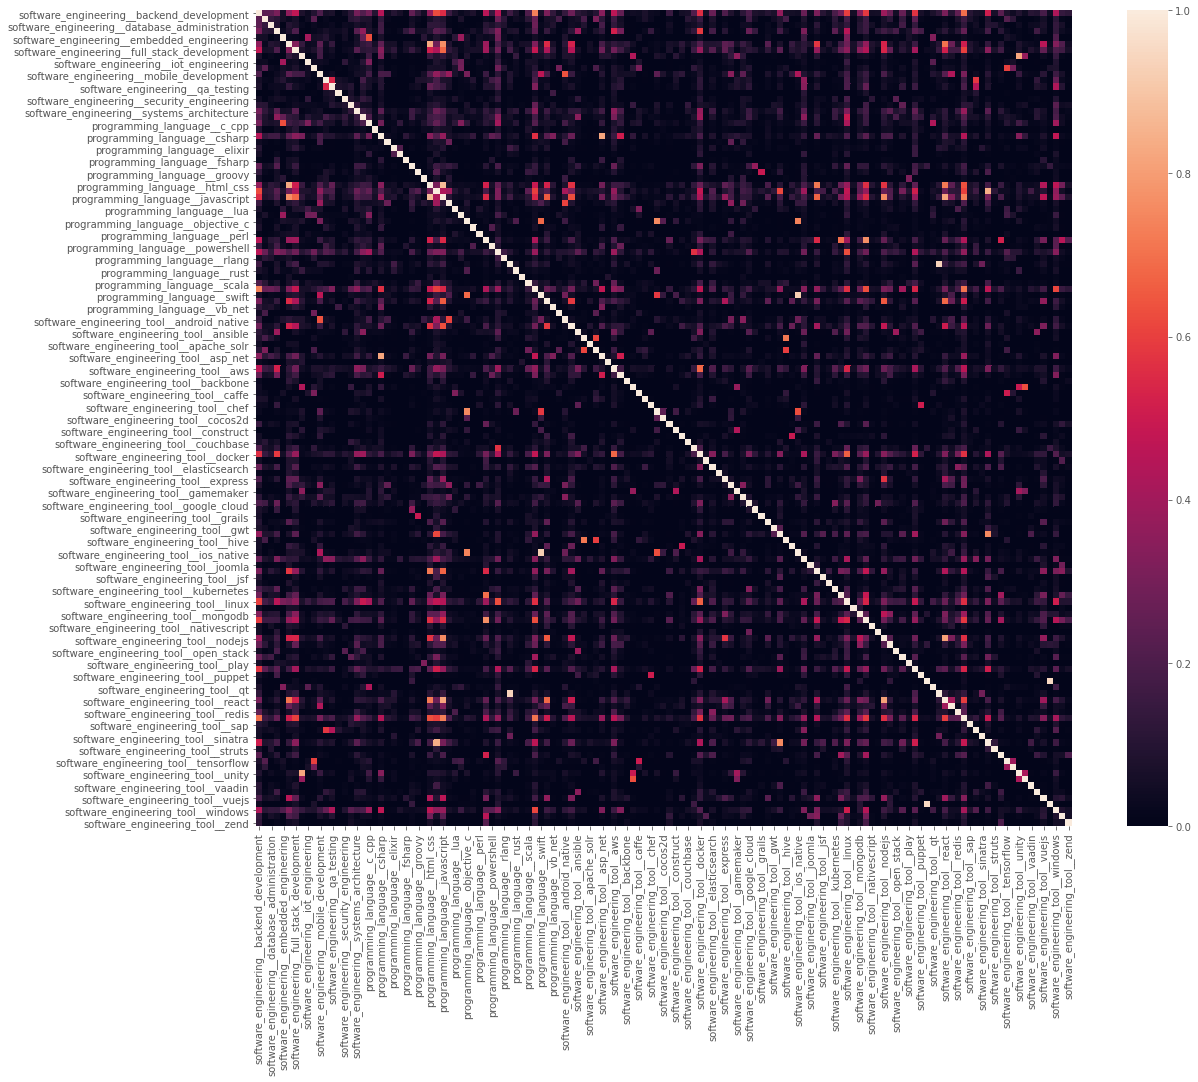

In [33]:
tf_idf = get_tf_idf(df_for_tfidf)
df_skills_similarities = pd.DataFrame(cosine_similarity(tf_idf.T))
df_skills_similarities.columns = df_for_tfidf.columns
df_skills_similarities.set_index(df_for_tfidf.columns, inplace=True)

f, ax = plt.subplots( figsize=(20,15))
sns.heatmap(df_skills_similarities, annot_kws={'size':20}, square=True, ax=ax)
plt.savefig(BACKUP_PATH + TF_IDF_KEY + '.last.clust.skills.png')
plt.show()

In [34]:
df_skills_similarities.sum().sort_values(ascending=False)

software_engineering_tool__rest_api                 25.791074
software_engineering__backend_development           23.584834
programming_language__javascript                    23.462441
programming_language__sql                           22.644732
software_engineering_tool__linux                    22.082623
                                                      ...    
software_engineering_tool__neo4j                     2.312525
software_engineering__robotic_process_automation     2.296675
software_engineering_tool__meteor                    2.191426
software_engineering_tool__apache_solr               2.156008
programming_language__sas                            1.728704
Length: 133, dtype: float64

In [65]:
y_pred = []

for ix, profile in X_val.iterrows():
    profile_skills = profile[profile>0].index
    profile_predictions = reccomend_skills(profile_skills,df_skills_similarities, isList=True)
    y_pred.append(profile_predictions[0])
    
    sys.stdout.write("\r Profile " + str(ix + 1) + '/' + str(X_val.shape[0]))
    sys.stdout.flush() 

 Profile 42332/42332

acc 0.33204195407729375


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall 0.33204195407729375


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precesion 0.4587592907960942
f1 0.29254384692916124


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


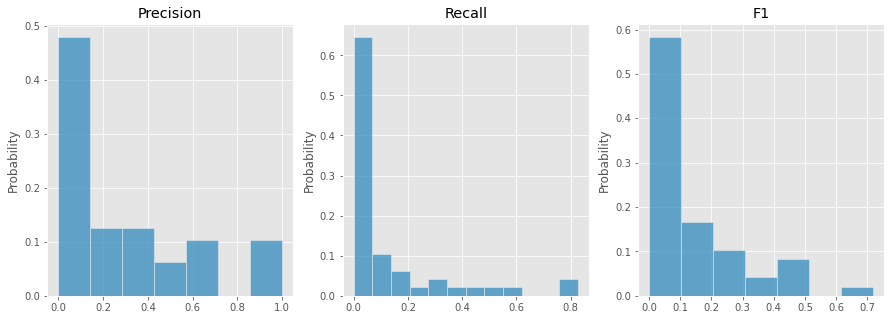

In [66]:
def display_scores(actual, pred):
    print('acc', accuracy_score(actual, pred))
    print('recall', recall_score(actual, pred, average = "weighted"))
    print('precesion', precision_score(actual, pred, average = "weighted"))
    print('f1', f1_score(actual, pred, average = "weighted"))
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
    sns.histplot(precision_score(actual, pred, average = None), stat='probability', ax=ax1).set(title='Precision')
    sns.histplot(recall_score(actual, pred, average = None), stat='probability', ax=ax2).set(title='Recall')
    sns.histplot(f1_score(actual, pred, average = None), stat='probability', ax=ax3).set(title='F1')
    plt.show()

display_scores(y_val, y_pred)

make_confusion_matrix(confusion_matrix(y_val, y_pred, labels=np.unique(y_val)), figsize=(30,20), 
                      count=True,
                      percent=False,
                      sum_stats=False,
                      categories=np.unique(y_val), cbar=False)

# acc 0.44921099877161486
# recall 0.44921099877161486
# precesion 0.4521575283981831
# f1 0.43575353154894264

In [35]:
reccomend_skills(['programming_language__javascript', 'software_engineering__frontend_development'],df_skills_similarities, n=15)
reccomend_skills(['programming_language__java',],df_skills_similarities, n=15)
reccomend_skills(['programming_language__csharp',],df_skills_similarities, n=15)
reccomend_skills(['software_engineering__backend_development', 'programming_language__javascript',],df_skills_similarities, n=10)

Recomendations for: ['programming_language__javascript', 'software_engineering__frontend_development']


skill     score
2                 programming_language__html_css  0.852377
3               software_engineering_tool__react  0.763462
4              software_engineering_tool__nodejs  0.644537
5              software_engineering_tool__jquery  0.628499
6            software_engineering_tool__rest_api  0.619721
7               programming_language__typescript  0.601542
8             software_engineering_tool__angular  0.576615
9   software_engineering__full_stack_development  0.506763
10                     programming_language__php  0.463642
11              software_engineering_tool__mysql  0.460097
12              software_engineering_tool__vuejs  0.459239
13     software_engineering__backend_development  0.454419
14                     programming_language__sql  0.432014

Recomendations for: ['programming_language__java']


skill     score
1              software_engineering_tool__spring  0.841220
2      software_engineering__backend_development  0.628887
3           software_engineering_tool__hibernate  0.617580
4            software_engineering_tool__rest_api  0.603752
5                      programming_language__sql  0.598273
6          software_engineering_tool__postgresql  0.515303
7              software_engineering_tool__docker  0.477589
8               software_engineering_tool__linux  0.474892
9               programming_language__javascript  0.433221
10  software_engineering__full_stack_development  0.428551
11     software_engineering_tool__android_native  0.412525
12                  programming_language__kotlin  0.394284
13            software_engineering_tool__jenkins  0.390627
14              software_engineering_tool__mysql  0.374044

Recomendations for: ['programming_language__csharp']


skill     score
1             software_engineering_tool__asp_net  0.823399
2                      programming_language__sql  0.566243
3               software_engineering_tool__azure  0.505660
4             software_engineering_tool__windows  0.474618
5      software_engineering__backend_development  0.447537
6            software_engineering_tool__rest_api  0.445724
7               programming_language__javascript  0.365274
8   software_engineering__full_stack_development  0.345688
9                 programming_language__html_css  0.342932
10              software_engineering_tool__unity  0.335635
11                  programming_language__vb_net  0.317178
12        software_engineering__game_development  0.306040
13                   programming_language__c_cpp  0.285834
14            software_engineering_tool__angular  0.267132

Recomendations for: ['software_engineering__backend_development', 'programming_language__javascript']


skill     score
2           software_engineering_tool__rest_api  0.714842
3                     programming_language__sql  0.640239
4                programming_language__html_css  0.620809
5  software_engineering__full_stack_development  0.578550
6             software_engineering_tool__nodejs  0.574427
7              software_engineering_tool__mysql  0.569004
8              software_engineering_tool__react  0.563680
9    software_engineering__frontend_development  0.562750

In [14]:
for ix, row in df_skills_similarities.iterrows():
    print('Skill name:', ix)
    print('-----------')
    row = row[row>0].sort_values(ascending=False)
    display(row.head(30))
#     for skill in 
#         print(skill)
#     print(list(zip((skill_names[row>0], row[row>0]))))
    print('\n')
#     display(row[row > 0.2])
#     print(row[row > 0.11])

Skill name: software_engineering__backend_development
-----------


software_engineering__backend_development       1.000000
programming_language__sql                       0.737960
software_engineering_tool__rest_api             0.698238
programming_language__java                      0.628887
software_engineering_tool__linux                0.600284
software_engineering_tool__mysql                0.588394
software_engineering_tool__postgresql           0.570610
software_engineering_tool__docker               0.559169
programming_language__javascript                0.552360
software_engineering_tool__spring               0.511056
software_engineering__full_stack_development    0.474227
software_engineering_tool__aws                  0.464554
programming_language__python                    0.457454
programming_language__php                       0.453882
programming_language__csharp                    0.447537
software_engineering_tool__windows              0.432120
software_engineering_tool__nodejs               0.387838
software_engineering_tool__hibe



Skill name: software_engineering__data_engineering
-----------


software_engineering__data_engineering           1.000000
software_engineering_tool__apache_spark          0.315483
programming_language__python                     0.272113
programming_language__sql                        0.262214
software_engineering_tool__postgresql            0.240641
software_engineering__backend_development        0.234423
software_engineering__machine_learning           0.226634
software_engineering_tool__tensorflow            0.214937
software_engineering_tool__apache_hadoop         0.186722
software_engineering_tool__amazon_ml             0.180343
software_engineering_tool__linux                 0.178233
software_engineering_tool__hive                  0.176861
software_engineering_tool__google_cloud          0.169730
software_engineering_tool__rest_api              0.161992
software_engineering_tool__mysql                 0.158005
software_engineering_tool__aws                   0.157754
software_engineering_tool__docker                0.147987
software_engin



Skill name: software_engineering__database_administration
-----------


software_engineering__database_administration    1.000000
programming_language__sql                        0.276251
software_engineering__backend_development        0.234786
software_engineering_tool__asp_net               0.184837
software_engineering_tool__oracle                0.173060
programming_language__csharp                     0.167517
software_engineering_tool__mysql                 0.158659
software_engineering_tool__postgresql            0.137390
software_engineering__data_engineering           0.137206
software_engineering_tool__windows               0.134805
software_engineering_tool__linux                 0.131951
software_engineering_tool__aws                   0.130394
software_engineering_tool__rest_api              0.124804
programming_language__html_css                   0.121197
programming_language__python                     0.118427
programming_language__java                       0.117849
software_engineering_tool__jquery                0.115582
programming_la



Skill name: software_engineering__devops_engineering
-----------


software_engineering__devops_engineering        1.000000
software_engineering_tool__docker               0.586035
software_engineering_tool__aws                  0.518719
software_engineering_tool__linux                0.455939
software_engineering_tool__ansible              0.388114
programming_language__bash                      0.362027
programming_language__python                    0.327544
software_engineering_tool__jenkins              0.313364
software_engineering__backend_development       0.306945
software_engineering_tool__azure                0.295025
software_engineering_tool__google_cloud         0.267155
software_engineering_tool__rest_api             0.257009
programming_language__sql                       0.240670
software_engineering_tool__kubernetes           0.238225
software_engineering_tool__postgresql           0.234446
software_engineering__systems_architecture      0.228758
programming_language__java                      0.228251
programming_language__golang   



Skill name: software_engineering__embedded_engineering
-----------


software_engineering__embedded_engineering    1.000000
programming_language__c_cpp                   0.631879
software_engineering__iot_engineering         0.408710
programming_language__matlab                  0.385727
software_engineering_tool__qt                 0.325655
software_engineering_tool__linux              0.308738
programming_language__python                  0.291533
programming_language__bash                    0.258518
software_engineering_tool__windows            0.204262
software_engineering_tool__jenkins            0.162637
programming_language__lua                     0.113989
programming_language__haskell                 0.108246
software_engineering__qa_automation           0.097199
software_engineering_tool__android_native     0.079030
programming_language__java                    0.078230
programming_language__objective_c             0.068783
programming_language__csharp                  0.067979
software_engineering_tool__play               0.063645
software_e



Skill name: software_engineering__frontend_development
-----------


software_engineering__frontend_development      1.000000
programming_language__html_css                  0.830562
programming_language__javascript                0.769022
software_engineering_tool__react                0.704579
software_engineering_tool__jquery               0.581505
programming_language__typescript                0.546907
software_engineering_tool__nodejs               0.528059
software_engineering_tool__angular              0.522408
software_engineering_tool__rest_api             0.507994
software_engineering_tool__vuejs                0.455171
programming_language__php                       0.382834
software_engineering_tool__mysql                0.370579
software_engineering__backend_development       0.356478
software_engineering__full_stack_development    0.330653
software_engineering_tool__windows              0.328441
programming_language__sql                       0.321510
software_engineering_tool__linux                0.277694
programming_language__java     



Skill name: software_engineering__full_stack_development
-----------


software_engineering__full_stack_development    1.000000
programming_language__javascript                0.682872
software_engineering_tool__rest_api             0.604439
software_engineering_tool__nodejs               0.536204
software_engineering_tool__react                0.519511
programming_language__html_css                  0.511666
programming_language__sql                       0.485781
software_engineering__backend_development       0.474227
software_engineering_tool__angular              0.448612
software_engineering_tool__mysql                0.441367
programming_language__java                      0.428551
programming_language__typescript                0.428023
software_engineering_tool__postgresql           0.404868
programming_language__php                       0.401795
software_engineering_tool__docker               0.378566
software_engineering_tool__jquery               0.369432
software_engineering_tool__linux                0.352834
programming_language__csharp   



Skill name: software_engineering__game_development
-----------


software_engineering__game_development          1.000000
software_engineering_tool__unity                0.821271
software_engineering_tool__blender              0.433868
software_engineering_tool__unreal_engine        0.371981
software_engineering_tool__gamemaker            0.354363
programming_language__csharp                    0.306040
software_engineering__mobile_development        0.172926
programming_language__c_cpp                     0.157303
programming_language__html_css                  0.145826
software_engineering_tool__windows              0.143805
software_engineering__frontend_development      0.139666
programming_language__rust                      0.138167
software_engineering_tool__firebase             0.135107
programming_language__javascript                0.125256
software_engineering_tool__google_apis          0.121325
programming_language__typescript                0.112154
software_engineering_tool__construct            0.108783
software_engineering_tool__reac



Skill name: software_engineering__iot_engineering
-----------


software_engineering__iot_engineering           1.000000
software_engineering__embedded_engineering      0.408710
programming_language__c_cpp                     0.318291
programming_language__matlab                    0.281291
software_engineering_tool__qt                   0.226636
programming_language__lua                       0.173428
software_engineering_tool__linux                0.151577
programming_language__python                    0.150924
software_engineering__security_engineering      0.123779
programming_language__bash                      0.101285
software_engineering_tool__windows              0.087367
software_engineering_tool__caffe                0.080011
programming_language__java                      0.079050
software_engineering_tool__postgresql           0.074277
software_engineering_tool__rest_api             0.062867
programming_language__scala                     0.060826
software_engineering_tool__angular              0.059692
software_engineering_tool__torc



Skill name: software_engineering__machine_learning
-----------


software_engineering__machine_learning          1.000000
software_engineering_tool__tensorflow           0.605137
software_engineering_tool__caffe                0.308217
software_engineering_tool__torch                0.297083
programming_language__matlab                    0.294668
software_engineering_tool__amazon_ml            0.291087
programming_language__python                    0.282625
software_engineering__data_engineering          0.226634
software_engineering_tool__apache_spark         0.188939
software_engineering_tool__django               0.123184
software_engineering_tool__blender              0.102341
programming_language__sql                       0.099880
programming_language__c_cpp                     0.096663
programming_language__rlang                     0.096033
software_engineering_tool__google_cloud         0.093179
software_engineering__backend_development       0.091633
software_engineering_tool__linux                0.084645
software_engineering_tool__wind



Skill name: software_engineering__mobile_development
-----------


software_engineering__mobile_development        1.000000
software_engineering_tool__android_native       0.639682
programming_language__swift                     0.466243
software_engineering_tool__react_native         0.433000
software_engineering_tool__ios_native           0.427814
programming_language__kotlin                    0.377582
programming_language__java                      0.359776
software_engineering_tool__firebase             0.347348
software_engineering_tool__rest_api             0.305697
programming_language__objective_c               0.299952
programming_language__javascript                0.265383
software_engineering__frontend_development      0.241672
software_engineering_tool__google_apis          0.239042
software_engineering_tool__cocoa                0.235370
software_engineering_tool__react                0.224018
programming_language__html_css                  0.209542
software_engineering__backend_development       0.201599
software_engineering_tool__node



Skill name: software_engineering__qa_automation
-----------


software_engineering__qa_automation           1.000000
software_engineering_tool__selenium           0.581690
software_engineering__qa_testing              0.538872
software_engineering_tool__jenkins            0.362478
software_engineering_tool__windows            0.258854
programming_language__python                  0.222425
programming_language__sql                     0.192548
software_engineering_tool__linux              0.191605
programming_language__java                    0.186429
programming_language__bash                    0.179684
programming_language__powershell              0.167133
software_engineering_tool__rest_api           0.144996
software_engineering_tool__mysql              0.132496
software_engineering_tool__vagrant            0.128388
software_engineering_tool__docker             0.119161
programming_language__csharp                  0.097552
software_engineering__embedded_engineering    0.097199
software_engineering_tool__azure              0.096079
programmin



Skill name: software_engineering__qa_testing
-----------


software_engineering__qa_testing              1.000000
software_engineering__qa_automation           0.538872
software_engineering_tool__selenium           0.441410
software_engineering_tool__windows            0.432292
software_engineering_tool__jenkins            0.340848
programming_language__sql                     0.316465
software_engineering_tool__mysql              0.252309
programming_language__html_css                0.250627
software_engineering_tool__linux              0.199928
programming_language__java                    0.194493
software_engineering_tool__rest_api           0.193882
programming_language__python                  0.189313
software_engineering_tool__postgresql         0.154265
programming_language__javascript              0.152288
software_engineering__frontend_development    0.135908
software_engineering_tool__oracle             0.132442
software_engineering_tool__azure              0.116818
software_engineering_tool__google_cloud       0.115610
software_e



Skill name: software_engineering__robotic_process_automation
-----------


software_engineering__robotic_process_automation    1.000000
programming_language__vb_net                        0.160487
software_engineering_tool__jenkins                  0.107585
software_engineering_tool__selenium                 0.096914
software_engineering__qa_testing                    0.077953
software_engineering_tool__mysql                    0.070882
programming_language__python                        0.070446
programming_language__bash                          0.069799
software_engineering__systems_analysis              0.065307
software_engineering_tool__aws                      0.064482
software_engineering__qa_automation                 0.062056
programming_language__html_css                      0.051232
programming_language__csharp                        0.050135
software_engineering_tool__rest_api                 0.049580
software_engineering_tool__docker                   0.045037
software_engineering_tool__sap                      0.033945
software_engineering__de



Skill name: software_engineering__security_engineering
-----------


software_engineering__security_engineering    1.000000
software_engineering_tool__open_stack         0.226557
software_engineering_tool__linux              0.186252
programming_language__bash                    0.135431
software_engineering__iot_engineering         0.123779
software_engineering_tool__ansible            0.123010
programming_language__python                  0.117673
software_engineering_tool__nativescript       0.115836
software_engineering_tool__docker             0.101103
programming_language__c_cpp                   0.096228
software_engineering_tool__kubernetes         0.093836
software_engineering_tool__windows            0.091367
software_engineering__systems_analysis        0.086811
software_engineering_tool__jenkins            0.085553
programming_language__lua                     0.074377
software_engineering__qa_testing              0.065496
software_engineering_tool__google_apis        0.064212
software_engineering_tool__rest_api           0.062141
programmin



Skill name: software_engineering__systems_analysis
-----------


software_engineering__systems_analysis              1.000000
programming_language__sql                           0.256996
software_engineering_tool__oracle                   0.248634
software_engineering_tool__windows                  0.229658
software_engineering_tool__mysql                    0.168473
software_engineering_tool__blender                  0.143393
software_engineering_tool__couchbase                0.132612
software_engineering__systems_architecture          0.127488
software_engineering_tool__postgresql               0.120855
software_engineering_tool__rest_api                 0.116922
software_engineering__backend_development           0.109853
programming_language__java                          0.108413
software_engineering_tool__linux                    0.106888
software_engineering__data_engineering              0.103976
software_engineering_tool__sap                      0.103024
software_engineering_tool__jenkins                  0.097880
software_engineering__qa



Skill name: software_engineering__systems_architecture
-----------


software_engineering__systems_architecture      1.000000
software_engineering_tool__rest_api             0.375312
software_engineering_tool__docker               0.369970
software_engineering_tool__aws                  0.353525
programming_language__sql                       0.350639
software_engineering_tool__linux                0.323904
software_engineering__backend_development       0.295434
programming_language__java                      0.270526
software_engineering_tool__postgresql           0.254019
programming_language__csharp                    0.235463
software_engineering_tool__spring               0.232126
software_engineering__devops_engineering        0.228758
software_engineering_tool__nosql                0.227682
software_engineering__full_stack_development    0.224661
software_engineering_tool__jenkins              0.222992
programming_language__javascript                0.210120
software_engineering_tool__azure                0.191323
software_engineering_tool__mysq



Skill name: programming_language__bash
-----------


programming_language__bash                    1.000000
software_engineering_tool__linux              0.491434
software_engineering_tool__docker             0.394318
software_engineering__devops_engineering      0.362027
software_engineering_tool__jenkins            0.347711
software_engineering_tool__ansible            0.347093
programming_language__python                  0.340418
software_engineering_tool__aws                0.304008
software_engineering__embedded_engineering    0.258518
software_engineering_tool__rest_api           0.216195
software_engineering__backend_development     0.213102
software_engineering_tool__windows            0.199001
programming_language__c_cpp                   0.196130
programming_language__java                    0.195183
software_engineering_tool__open_stack         0.186219
software_engineering__qa_automation           0.179684
programming_language__sql                     0.178194
software_engineering_tool__postgresql         0.172617
programmin



Skill name: programming_language__c_cpp
-----------


programming_language__c_cpp                     1.000000
software_engineering__embedded_engineering      0.631879
software_engineering_tool__qt                   0.433953
software_engineering_tool__linux                0.419032
programming_language__python                    0.403778
software_engineering_tool__windows              0.397332
programming_language__matlab                    0.325195
software_engineering__iot_engineering           0.318291
software_engineering__backend_development       0.296494
programming_language__csharp                    0.285834
programming_language__java                      0.251575
programming_language__sql                       0.217857
programming_language__bash                      0.196130
software_engineering_tool__android_native       0.172553
programming_language__javascript                0.170855
software_engineering_tool__unity                0.169043
software_engineering__mobile_development        0.168268
software_engineering__frontend_



Skill name: programming_language__clojure
-----------


programming_language__clojure                   1.000000
software_engineering__full_stack_development    0.101722
software_engineering_tool__aws                  0.098969
software_engineering__backend_development       0.096871
software_engineering_tool__docker               0.088651
software_engineering_tool__postgresql           0.079792
programming_language__java                      0.078408
programming_language__python                    0.077344
programming_language__scala                     0.074469
software_engineering_tool__rest_api             0.067102
software_engineering_tool__react                0.062619
programming_language__javascript                0.057553
software_engineering_tool__linux                0.056477
software_engineering_tool__django               0.055174
software_engineering__frontend_development      0.054870
programming_language__kotlin                    0.050493
software_engineering_tool__mongodb              0.046661
software_engineering_tool__nosq



Skill name: programming_language__csharp
-----------


programming_language__csharp                    1.000000
software_engineering_tool__asp_net              0.823399
programming_language__sql                       0.566243
software_engineering_tool__azure                0.505660
software_engineering_tool__windows              0.474618
software_engineering__backend_development       0.447537
software_engineering_tool__rest_api             0.445724
programming_language__javascript                0.365274
software_engineering__full_stack_development    0.345688
programming_language__html_css                  0.342932
software_engineering_tool__unity                0.335635
programming_language__vb_net                    0.317178
software_engineering__game_development          0.306040
programming_language__c_cpp                     0.285834
software_engineering_tool__angular              0.267132
software_engineering_tool__jquery               0.256485
programming_language__powershell                0.249622
software_engineering__frontend_



Skill name: programming_language__dart
-----------


programming_language__dart                      1.000000
programming_language__kotlin                    0.266180
software_engineering_tool__firebase             0.247615
software_engineering__mobile_development        0.183225
software_engineering_tool__android_native       0.173306
software_engineering_tool__google_apis          0.123266
software_engineering_tool__rest_api             0.103290
software_engineering_tool__postgresql           0.089530
software_engineering_tool__aws                  0.086093
programming_language__java                      0.082169
software_engineering_tool__react                0.080759
programming_language__javascript                0.070510
software_engineering_tool__react_native         0.068936
software_engineering__full_stack_development    0.067326
software_engineering__frontend_development      0.056033
programming_language__swift                     0.053978
software_engineering_tool__docker               0.048202
software_engineering_tool__ios_



Skill name: programming_language__elixir
-----------


programming_language__elixir                    1.000000
programming_language__erlang                    0.207888
programming_language__ruby                      0.169008
software_engineering_tool__postgresql           0.147841
software_engineering__full_stack_development    0.121099
programming_language__rust                      0.108138
software_engineering_tool__rails                0.100433
software_engineering_tool__sinatra              0.098999
software_engineering__backend_development       0.096003
programming_language__javascript                0.090585
software_engineering_tool__docker               0.090272
software_engineering_tool__react                0.082461
programming_language__typescript                0.078746
software_engineering_tool__rest_api             0.076359
software_engineering_tool__elasticsearch        0.074277
programming_language__sql                       0.067281
software_engineering_tool__nodejs               0.064787
software_engineering__frontend_



Skill name: programming_language__erlang
-----------


programming_language__erlang                    1.000000
programming_language__elixir                    0.207888
software_engineering_tool__postgresql           0.151997
software_engineering_tool__jenkins              0.129021
programming_language__c_cpp                     0.121323
software_engineering_tool__docker               0.113409
software_engineering_tool__linux                0.099234
software_engineering_tool__windows              0.073914
programming_language__java                      0.071447
software_engineering__backend_development       0.058446
software_engineering_tool__google_cloud         0.053025
programming_language__ruby                      0.045461
software_engineering_tool__kubernetes           0.041079
programming_language__rust                      0.031301
software_engineering__devops_engineering        0.025650
programming_language__python                    0.025614
software_engineering__systems_architecture      0.025216
software_engineering_tool__rest



Skill name: programming_language__fsharp
-----------


programming_language__fsharp                    1.000000
software_engineering_tool__asp_net              0.150735
software_engineering__devops_engineering        0.131781
programming_language__csharp                    0.116478
software_engineering_tool__vuejs                0.107610
software_engineering_tool__angular              0.094805
software_engineering_tool__azure                0.087833
programming_language__powershell                0.086388
software_engineering__full_stack_development    0.060738
programming_language__html_css                  0.057401
programming_language__sql                       0.053398
programming_language__javascript                0.048642
software_engineering__frontend_development      0.046897
software_engineering_tool__windows              0.035136
software_engineering_tool__rest_api             0.026743
software_engineering__systems_architecture      0.025409
programming_language__typescript                0.024783
software_engineering_tool__kube



Skill name: programming_language__golang
-----------


programming_language__golang                    1.000000
software_engineering_tool__gorilla              0.371997
software_engineering_tool__docker               0.308666
software_engineering_tool__aws                  0.263600
software_engineering__backend_development       0.253720
software_engineering_tool__linux                0.247501
software_engineering__devops_engineering        0.221600
programming_language__python                    0.188663
software_engineering_tool__postgresql           0.173075
software_engineering_tool__rest_api             0.172130
software_engineering__systems_architecture      0.163368
software_engineering_tool__google_cloud         0.162901
programming_language__java                      0.156671
programming_language__bash                      0.155957
programming_language__kotlin                    0.151559
software_engineering_tool__pyramid              0.146536
software_engineering__full_stack_development    0.145031
software_engineering_tool__ansi



Skill name: programming_language__groovy
-----------


programming_language__groovy                    1.000000
software_engineering_tool__grails               0.488774
programming_language__java                      0.221758
software_engineering_tool__postgresql           0.195156
software_engineering_tool__spring               0.191742
programming_language__scala                     0.147684
software_engineering_tool__rest_api             0.140602
software_engineering__backend_development       0.131978
programming_language__sql                       0.124812
software_engineering_tool__docker               0.115931
software_engineering_tool__hibernate            0.108074
software_engineering_tool__jenkins              0.105512
software_engineering__systems_architecture      0.093023
software_engineering_tool__aws                  0.091041
software_engineering_tool__selenium             0.084353
software_engineering_tool__nosql                0.082316
software_engineering_tool__linux                0.076967
software_engineering__qa_automa



Skill name: programming_language__haskell
-----------


programming_language__haskell                   1.000000
software_engineering_tool__play                 0.319703
software_engineering_tool__android_native       0.148832
software_engineering_tool__google_apis          0.133120
software_engineering__embedded_engineering      0.108246
programming_language__kotlin                    0.098797
software_engineering_tool__jenkins              0.095702
software_engineering_tool__firebase             0.086998
programming_language__c_cpp                     0.077147
software_engineering__qa_automation             0.076252
programming_language__java                      0.066977
software_engineering__mobile_development        0.055336
software_engineering__devops_engineering        0.050854
software_engineering_tool__linux                0.050659
software_engineering__backend_development       0.048047
software_engineering__systems_architecture      0.048011
software_engineering_tool__docker               0.045358
software_engineering_tool__wind



Skill name: programming_language__html_css
-----------


programming_language__html_css                  1.000000
programming_language__javascript                0.874193
software_engineering__frontend_development      0.830562
software_engineering_tool__react                0.719899
software_engineering_tool__jquery               0.715822
software_engineering_tool__rest_api             0.633774
software_engineering_tool__nodejs               0.573860
software_engineering_tool__angular              0.566700
software_engineering_tool__mysql                0.559107
programming_language__typescript                0.524533
programming_language__php                       0.522479
software_engineering__full_stack_development    0.511666
programming_language__sql                       0.489518
software_engineering_tool__windows              0.467673
software_engineering_tool__vuejs                0.437738
software_engineering_tool__linux                0.382732
software_engineering__backend_development       0.367425
programming_language__csharp   



Skill name: programming_language__java
-----------


programming_language__java                      1.000000
software_engineering_tool__spring               0.841220
software_engineering__backend_development       0.628887
software_engineering_tool__hibernate            0.617580
software_engineering_tool__rest_api             0.603752
programming_language__sql                       0.598273
software_engineering_tool__postgresql           0.515303
software_engineering_tool__docker               0.477589
software_engineering_tool__linux                0.474892
programming_language__javascript                0.433221
software_engineering__full_stack_development    0.428551
software_engineering_tool__android_native       0.412525
programming_language__kotlin                    0.394284
software_engineering_tool__jenkins              0.390627
software_engineering_tool__mysql                0.374044
software_engineering_tool__aws                  0.366709
software_engineering__mobile_development        0.359776
software_engineering_tool__wind



Skill name: programming_language__javascript
-----------


programming_language__javascript                1.000000
programming_language__html_css                  0.874193
software_engineering_tool__react                0.822344
software_engineering__frontend_development      0.769022
software_engineering_tool__nodejs               0.761015
software_engineering_tool__rest_api             0.731447
software_engineering__full_stack_development    0.682872
software_engineering_tool__jquery               0.675493
programming_language__typescript                0.656177
software_engineering_tool__angular              0.630822
software_engineering__backend_development       0.552360
software_engineering_tool__mysql                0.549614
programming_language__php                       0.544450
programming_language__sql                       0.542518
software_engineering_tool__vuejs                0.463307
software_engineering_tool__linux                0.445487
programming_language__java                      0.433221
software_engineering_tool__dock



Skill name: programming_language__kotlin
-----------


programming_language__kotlin                    1.000000
software_engineering_tool__android_native       0.609197
programming_language__java                      0.394284
software_engineering__mobile_development        0.377582
software_engineering_tool__firebase             0.358806
software_engineering_tool__google_apis          0.280610
programming_language__dart                      0.266180
software_engineering_tool__rest_api             0.201620
programming_language__swift                     0.200250
software_engineering_tool__spring               0.168318
software_engineering__backend_development       0.154588
programming_language__golang                    0.151559
software_engineering_tool__jenkins              0.139693
software_engineering_tool__ios_native           0.135087
software_engineering_tool__postgresql           0.131902
software_engineering__full_stack_development    0.125650
programming_language__sql                       0.120239
software_engineering_tool__dock



Skill name: programming_language__lua
-----------


programming_language__lua                       1.000000
software_engineering_tool__caffe                0.317766
software_engineering_tool__redis                0.193336
software_engineering__iot_engineering           0.173428
software_engineering_tool__tensorflow           0.158913
software_engineering_tool__gorilla              0.123208
programming_language__c_cpp                     0.114331
software_engineering__embedded_engineering      0.113989
programming_language__golang                    0.109337
software_engineering_tool__docker               0.102054
programming_language__java                      0.097566
software_engineering_tool__unity                0.095125
software_engineering_tool__linux                0.093660
software_engineering_tool__spring               0.091203
software_engineering_tool__qt                   0.090324
software_engineering__game_development          0.089252
software_engineering_tool__postgresql           0.088800
software_engineering__systems_a



Skill name: programming_language__matlab
-----------


programming_language__matlab                  1.000000
software_engineering__embedded_engineering    0.385727
programming_language__c_cpp                   0.325195
software_engineering__machine_learning        0.294668
software_engineering__iot_engineering         0.281291
programming_language__python                  0.182172
software_engineering_tool__tensorflow         0.179242
software_engineering_tool__windows            0.151703
software_engineering_tool__qt                 0.128903
software_engineering_tool__linux              0.128637
software_engineering_tool__torch              0.079562
programming_language__rlang                   0.079456
software_engineering_tool__caffe              0.075994
programming_language__bash                    0.073215
software_engineering__data_engineering        0.071098
software_engineering_tool__amazon_ml          0.067805
programming_language__csharp                  0.061169
software_engineering_tool__google_cloud       0.054430
software_e



Skill name: programming_language__objective_c
-----------


programming_language__objective_c               1.000000
software_engineering_tool__cocoa                0.755449
software_engineering_tool__ios_native           0.741878
programming_language__swift                     0.683781
software_engineering__mobile_development        0.299952
software_engineering_tool__cocos2d              0.223358
programming_language__rust                      0.204503
software_engineering_tool__android_native       0.157622
software_engineering_tool__construct            0.127797
software_engineering_tool__firebase             0.125675
programming_language__c_cpp                     0.122626
software_engineering_tool__google_apis          0.116056
software_engineering_tool__rest_api             0.108520
programming_language__kotlin                    0.087756
software_engineering__game_development          0.080737
programming_language__java                      0.078307
software_engineering_tool__unity                0.070552
software_engineering__embedded_



Skill name: programming_language__openedge_abl
-----------


programming_language__openedge_abl              1.000000
programming_language__powershell                0.207650
software_engineering_tool__azure                0.142194
programming_language__csharp                    0.133870
software_engineering_tool__asp_net              0.116070
software_engineering__qa_automation             0.093672
software_engineering__systems_architecture      0.087426
software_engineering_tool__rest_api             0.083700
software_engineering__backend_development       0.076229
software_engineering__full_stack_development    0.062977
software_engineering_tool__windows              0.060647
software_engineering__devops_engineering        0.058867
programming_language__sql                       0.058085
programming_language__python                    0.055859
programming_language__javascript                0.038763
software_engineering__qa_testing                0.036909
programming_language__typescript                0.034300
programming_language__bash     



Skill name: programming_language__perl
-----------


programming_language__perl                      1.000000
software_engineering_tool__firebase             0.158981
software_engineering_tool__linux                0.117874
software_engineering_tool__docker               0.113432
programming_language__typescript                0.103534
programming_language__lua                       0.080297
software_engineering_tool__nodejs               0.077415
software_engineering_tool__react                0.070822
software_engineering_tool__chef                 0.067195
software_engineering_tool__caffe                0.064987
software_engineering__full_stack_development    0.059225
software_engineering_tool__ansible              0.058603
programming_language__python                    0.057372
software_engineering__frontend_development      0.055835
software_engineering_tool__django               0.050380
programming_language__javascript                0.049298
software_engineering__embedded_engineering      0.045430
software_engineering__iot_engin



Skill name: programming_language__php
-----------


programming_language__php                       1.000000
software_engineering_tool__mysql                0.766642
software_engineering_tool__laravel              0.696248
software_engineering_tool__jquery               0.546595
programming_language__javascript                0.544450
software_engineering_tool__symfony              0.522545
programming_language__html_css                  0.522479
software_engineering_tool__wordpress            0.454629
software_engineering__backend_development       0.453882
software_engineering_tool__rest_api             0.435912
programming_language__sql                       0.426270
software_engineering__full_stack_development    0.401795
software_engineering_tool__linux                0.394446
software_engineering__frontend_development      0.382834
software_engineering_tool__docker               0.295745
software_engineering_tool__vuejs                0.295245
software_engineering_tool__code_igniter         0.258761
software_engineering_tool__reac



Skill name: programming_language__powershell
-----------


programming_language__powershell                 1.000000
software_engineering_tool__azure                 0.268081
programming_language__csharp                     0.249622
software_engineering_tool__windows               0.230613
programming_language__openedge_abl               0.207650
software_engineering_tool__asp_net               0.198430
software_engineering__devops_engineering         0.178876
software_engineering__qa_automation              0.167133
software_engineering__backend_development        0.144496
software_engineering_tool__selenium              0.140490
programming_language__sql                        0.139653
software_engineering_tool__rest_api              0.130680
programming_language__bash                       0.126058
software_engineering_tool__docker                0.125791
software_engineering_tool__kubernetes            0.109177
software_engineering_tool__linux                 0.107147
programming_language__python                     0.100680
software_engin



Skill name: programming_language__python
-----------


programming_language__python                    1.000000
software_engineering_tool__linux                0.630407
software_engineering_tool__django               0.567478
software_engineering__backend_development       0.457454
software_engineering_tool__postgresql           0.437142
software_engineering_tool__docker               0.430018
programming_language__c_cpp                     0.403778
software_engineering_tool__aws                  0.383105
programming_language__sql                       0.380815
software_engineering_tool__rest_api             0.363262
programming_language__bash                      0.340418
software_engineering_tool__windows              0.339441
software_engineering__devops_engineering        0.327544
programming_language__javascript                0.317800
programming_language__java                      0.317294
software_engineering__embedded_engineering      0.291533
software_engineering_tool__jenkins              0.284951
software_engineering__full_stac



Skill name: programming_language__rlang
-----------


programming_language__rlang                      1.000000
programming_language__python                     0.157128
software_engineering_tool__tensorflow            0.127807
software_engineering__data_engineering           0.114913
software_engineering_tool__torch                 0.110191
software_engineering__machine_learning           0.096033
software_engineering__database_administration    0.085310
software_engineering_tool__linux                 0.082160
programming_language__matlab                     0.079456
software_engineering_tool__postgresql            0.074978
software_engineering_tool__amazon_ml             0.073060
programming_language__html_css                   0.069712
programming_language__sql                        0.068167
software_engineering_tool__aws                   0.065984
software_engineering_tool__react                 0.063414
programming_language__javascript                 0.061888
software_engineering_tool__mongodb               0.061760
software_engin



Skill name: programming_language__ruby
-----------


programming_language__ruby                      1.000000
software_engineering_tool__rails                0.938461
software_engineering_tool__sinatra              0.274105
software_engineering_tool__postgresql           0.222706
software_engineering__full_stack_development    0.176385
software_engineering_tool__rest_api             0.172630
programming_language__elixir                    0.169008
programming_language__javascript                0.167626
software_engineering__backend_development       0.160418
software_engineering_tool__react                0.145983
software_engineering_tool__docker               0.138040
software_engineering_tool__redis                0.134823
software_engineering_tool__elasticsearch        0.130786
software_engineering_tool__linux                0.129618
programming_language__sql                       0.121334
programming_language__html_css                  0.120953
software_engineering__frontend_development      0.117058
software_engineering_tool__aws 



Skill name: programming_language__rust
-----------


programming_language__rust                      1.000000
software_engineering_tool__cocoa                0.270949
programming_language__objective_c               0.204503
software_engineering_tool__unity                0.149437
software_engineering__game_development          0.138167
software_engineering__systems_architecture      0.119234
programming_language__elixir                    0.108138
programming_language__c_cpp                     0.099326
software_engineering_tool__linux                0.092617
software_engineering__devops_engineering        0.082305
programming_language__csharp                    0.072241
software_engineering__backend_development       0.070365
programming_language__ruby                      0.063210
software_engineering_tool__windows              0.059167
software_engineering_tool__postgresql           0.052728
software_engineering_tool__docker               0.050318
software_engineering_tool__redis                0.050302
software_engineering__full_stac



Skill name: programming_language__sas
-----------


programming_language__sas                       1.000000
software_engineering_tool__aurelia              0.084793
programming_language__html_css                  0.065599
software_engineering__frontend_development      0.054929
programming_language__javascript                0.047103
software_engineering_tool__react                0.042619
software_engineering_tool__jquery               0.037913
software_engineering_tool__google_apis          0.033350
software_engineering_tool__angular              0.027531
software_engineering_tool__mysql                0.025169
software_engineering__data_engineering          0.024160
software_engineering_tool__postgresql           0.023721
software_engineering_tool__aws                  0.018518
programming_language__sql                       0.017010
programming_language__typescript                0.014558
software_engineering__systems_analysis          0.013685
software_engineering_tool__nodejs               0.013520
software_engineering_tool__wind



Skill name: programming_language__scala
-----------


programming_language__scala                     1.000000
software_engineering_tool__apache_spark         0.283281
software_engineering_tool__aws                  0.253918
programming_language__java                      0.237898
software_engineering__backend_development       0.206043
software_engineering_tool__docker               0.186001
software_engineering_tool__postgresql           0.182255
software_engineering_tool__spring               0.180155
software_engineering_tool__rest_api             0.163861
programming_language__groovy                    0.147684
software_engineering__systems_architecture      0.142113
programming_language__sql                       0.141329
software_engineering_tool__elasticsearch        0.141303
software_engineering__full_stack_development    0.125693
software_engineering_tool__hive                 0.122068
software_engineering_tool__nosql                0.121734
software_engineering_tool__linux                0.119446
software_engineering_tool__play



Skill name: programming_language__sql
-----------


programming_language__sql                        1.000000
software_engineering__backend_development        0.737960
software_engineering_tool__rest_api              0.707564
software_engineering_tool__mysql                 0.632558
software_engineering_tool__windows               0.616458
programming_language__java                       0.598273
software_engineering_tool__linux                 0.566337
programming_language__csharp                     0.566243
programming_language__javascript                 0.542518
software_engineering_tool__postgresql            0.533296
programming_language__html_css                   0.489518
software_engineering__full_stack_development     0.485781
software_engineering_tool__asp_net               0.478999
software_engineering_tool__docker                0.473785
software_engineering_tool__spring                0.466835
programming_language__php                        0.426270
software_engineering_tool__oracle                0.400869
programming_la



Skill name: programming_language__swift
-----------


programming_language__swift                     1.000000
software_engineering_tool__ios_native           0.922329
programming_language__objective_c               0.683781
software_engineering_tool__cocoa                0.584998
software_engineering__mobile_development        0.466243
software_engineering_tool__android_native       0.286972
programming_language__kotlin                    0.200250
software_engineering_tool__react_native         0.189461
software_engineering_tool__construct            0.182626
software_engineering_tool__rest_api             0.162484
software_engineering_tool__firebase             0.151547
programming_language__java                      0.150554
software_engineering_tool__cocos2d              0.140441
software_engineering_tool__google_apis          0.132667
programming_language__javascript                0.103604
software_engineering__full_stack_development    0.096126
software_engineering_tool__react                0.085443
software_engineering__frontend_



Skill name: programming_language__typescript
-----------


programming_language__typescript                1.000000
software_engineering_tool__react                0.684336
programming_language__javascript                0.656177
software_engineering_tool__nodejs               0.651914
software_engineering_tool__angular              0.588391
software_engineering__frontend_development      0.546907
programming_language__html_css                  0.524533
software_engineering_tool__rest_api             0.501006
software_engineering__full_stack_development    0.428023
software_engineering_tool__express              0.427116
software_engineering_tool__vuejs                0.360704
software_engineering_tool__docker               0.311212
software_engineering__backend_development       0.309989
software_engineering_tool__jquery               0.299429
software_engineering_tool__react_native         0.268040
programming_language__sql                       0.266224
software_engineering_tool__graphql              0.244930
software_engineering_tool__ioni



Skill name: programming_language__vb_net
-----------


programming_language__vb_net                        1.000000
software_engineering_tool__asp_net                  0.318951
programming_language__csharp                        0.317178
programming_language__sql                           0.213166
software_engineering__robotic_process_automation    0.160487
software_engineering__backend_development           0.129457
software_engineering_tool__windows                  0.113675
software_engineering__full_stack_development        0.109793
software_engineering_tool__rest_api                 0.107891
programming_language__html_css                      0.106855
software_engineering_tool__mysql                    0.104487
software_engineering_tool__jquery                   0.093324
programming_language__javascript                    0.087509
software_engineering__database_administration       0.083453
software_engineering__data_engineering              0.068324
software_engineering_tool__oracle                   0.066844
programming_language__c_



Skill name: software_engineering_tool__amazon_ml
-----------


software_engineering_tool__amazon_ml          1.000000
software_engineering__machine_learning        0.291087
software_engineering_tool__apache_spark       0.229150
software_engineering__data_engineering        0.180343
programming_language__python                  0.090612
software_engineering_tool__caffe              0.088768
software_engineering__systems_architecture    0.075762
programming_language__rlang                   0.073060
programming_language__matlab                  0.067805
software_engineering_tool__tensorflow         0.066237
software_engineering_tool__docker             0.061992
programming_language__sql                     0.055121
software_engineering_tool__aws                0.052275
programming_language__scala                   0.046653
programming_language__csharp                  0.045654
software_engineering__backend_development     0.045643
programming_language__bash                    0.031106
software_engineering_tool__postgresql         0.026372
software_e



Skill name: software_engineering_tool__android_native
-----------


software_engineering_tool__android_native       1.000000
software_engineering__mobile_development        0.639682
programming_language__kotlin                    0.609197
programming_language__java                      0.412525
software_engineering_tool__google_apis          0.342289
software_engineering_tool__firebase             0.304550
programming_language__swift                     0.286972
software_engineering_tool__ios_native           0.273885
software_engineering_tool__rest_api             0.206899
software_engineering_tool__react_native         0.180698
programming_language__dart                      0.173306
programming_language__c_cpp                     0.172553
programming_language__objective_c               0.157622
programming_language__haskell                   0.148832
software_engineering__backend_development       0.139963
software_engineering_tool__windows              0.122834
software_engineering_tool__mysql                0.119484
software_engineering_tool__jenk



Skill name: software_engineering_tool__angular
-----------


software_engineering_tool__angular              1.000000
programming_language__javascript                0.630822
programming_language__typescript                0.588391
programming_language__html_css                  0.566700
software_engineering__frontend_development      0.522408
software_engineering_tool__react                0.501809
software_engineering_tool__nodejs               0.480190
software_engineering_tool__rest_api             0.458722
software_engineering__full_stack_development    0.448612
software_engineering_tool__jquery               0.404102
software_engineering_tool__vuejs                0.317700
programming_language__java                      0.308832
programming_language__sql                       0.287887
software_engineering__backend_development       0.273973
programming_language__csharp                    0.267132
software_engineering_tool__ionic                0.266956
software_engineering_tool__spring               0.266882
software_engineering_tool__mong



Skill name: software_engineering_tool__ansible
-----------


software_engineering_tool__ansible              1.000000
software_engineering__devops_engineering        0.388114
software_engineering_tool__open_stack           0.387130
software_engineering_tool__vagrant              0.349844
programming_language__bash                      0.347093
software_engineering_tool__docker               0.322166
software_engineering_tool__aws                  0.300445
software_engineering_tool__linux                0.281969
software_engineering_tool__jenkins              0.265993
programming_language__python                    0.241796
software_engineering_tool__chef                 0.240312
software_engineering_tool__google_cloud         0.220132
software_engineering_tool__kubernetes           0.211638
software_engineering_tool__puppet               0.160346
programming_language__golang                    0.144349
software_engineering__systems_architecture      0.131184
software_engineering_tool__azure                0.125669
software_engineering__security_



Skill name: software_engineering_tool__apache_hadoop
-----------


software_engineering_tool__apache_hadoop         1.000000
software_engineering_tool__hive                  0.715709
software_engineering_tool__apache_spark          0.611843
software_engineering__data_engineering           0.186722
software_engineering_tool__django                0.165238
programming_language__python                     0.131989
software_engineering_tool__aws                   0.107305
software_engineering_tool__linux                 0.098980
programming_language__scala                      0.093800
software_engineering__database_administration    0.088180
software_engineering__backend_development        0.085410
software_engineering_tool__mongodb               0.076805
software_engineering_tool__rest_api              0.070181
software_engineering_tool__tensorflow            0.067430
programming_language__sql                        0.066292
software_engineering_tool__postgresql            0.061894
software_engineering_tool__mysql                 0.059982
software_engin



Skill name: software_engineering_tool__apache_solr
-----------


software_engineering_tool__apache_solr          1.000000
software_engineering_tool__jenkins              0.109633
software_engineering_tool__angular              0.087255
programming_language__typescript                0.076019
software_engineering_tool__spring               0.074163
programming_language__java                      0.060675
software_engineering_tool__rest_api             0.060403
software_engineering_tool__puppet               0.052200
software_engineering__backend_development       0.050657
software_engineering__full_stack_development    0.049143
software_engineering__frontend_development      0.049107
programming_language__javascript                0.044308
software_engineering_tool__drupal               0.031417
software_engineering__systems_architecture      0.030783
programming_language__sql                       0.024044
software_engineering__systems_analysis          0.023158
programming_language__php                       0.017070
software_engineering_tool__linu



Skill name: software_engineering_tool__apache_spark
-----------


software_engineering_tool__apache_spark       1.000000
software_engineering_tool__apache_hadoop      0.611843
software_engineering_tool__hive               0.595265
software_engineering__data_engineering        0.315483
programming_language__scala                   0.283281
software_engineering_tool__amazon_ml          0.229150
software_engineering__machine_learning        0.188939
software_engineering_tool__tensorflow         0.167894
software_engineering_tool__aws                0.160785
software_engineering_tool__cassandra          0.129633
programming_language__python                  0.127016
software_engineering__backend_development     0.101056
software_engineering_tool__docker             0.098096
software_engineering_tool__caffe              0.096666
software_engineering_tool__elasticsearch      0.095822
software_engineering_tool__puppet             0.080480
software_engineering__systems_architecture    0.080211
software_engineering_tool__google_cloud       0.079191
software_e



Skill name: software_engineering_tool__asp_net
-----------


software_engineering_tool__asp_net               1.000000
programming_language__csharp                     0.823399
software_engineering_tool__azure                 0.511364
programming_language__sql                        0.478999
software_engineering_tool__rest_api              0.379822
software_engineering__backend_development        0.343196
software_engineering_tool__windows               0.323521
programming_language__vb_net                     0.318951
programming_language__javascript                 0.293712
programming_language__html_css                   0.289606
software_engineering__full_stack_development     0.283917
software_engineering_tool__jquery                0.251945
software_engineering_tool__angular               0.210532
programming_language__typescript                 0.205465
programming_language__powershell                 0.198430
software_engineering__database_administration    0.184837
software_engineering__frontend_development       0.182519
software_engin



Skill name: software_engineering_tool__aurelia
-----------


software_engineering_tool__aurelia              1.000000
programming_language__typescript                0.116393
software_engineering__game_development          0.090559
programming_language__sas                       0.084793
programming_language__kotlin                    0.079624
software_engineering__frontend_development      0.075683
software_engineering__full_stack_development    0.069311
programming_language__javascript                0.064735
software_engineering_tool__angular              0.054987
software_engineering_tool__react                0.052636
software_engineering_tool__spring               0.049536
programming_language__html_css                  0.048165
software_engineering_tool__rest_api             0.045931
programming_language__java                      0.044983
software_engineering__backend_development       0.038333
software_engineering_tool__jquery               0.035971
software_engineering_tool__asp_net              0.034662
software_engineering_tool__lara



Skill name: software_engineering_tool__aws
-----------


software_engineering_tool__aws                  1.000000
software_engineering_tool__docker               0.681966
software_engineering_tool__linux                0.536522
software_engineering__devops_engineering        0.518719
software_engineering__backend_development       0.464554
software_engineering_tool__rest_api             0.459448
software_engineering_tool__postgresql           0.417131
programming_language__python                    0.383105
programming_language__java                      0.366709
programming_language__sql                       0.361544
software_engineering__systems_architecture      0.353525
software_engineering_tool__jenkins              0.321192
software_engineering_tool__spring               0.312326
programming_language__bash                      0.304008
programming_language__javascript                0.300814
software_engineering_tool__ansible              0.300445
software_engineering__full_stack_development    0.284156
software_engineering_tool__mysq



Skill name: software_engineering_tool__azure
-----------


software_engineering_tool__azure                1.000000
software_engineering_tool__asp_net              0.511364
programming_language__csharp                    0.505660
software_engineering_tool__windows              0.328810
programming_language__sql                       0.306587
software_engineering_tool__rest_api             0.299949
software_engineering__devops_engineering        0.295025
programming_language__powershell                0.268081
software_engineering__backend_development       0.255842
software_engineering__systems_architecture      0.191323
software_engineering_tool__docker               0.179371
programming_language__javascript                0.177373
software_engineering_tool__nosql                0.174593
software_engineering_tool__aws                  0.170724
software_engineering__full_stack_development    0.165031
programming_language__html_css                  0.154778
software_engineering_tool__google_cloud         0.152788
software_engineering_tool__linu



Skill name: software_engineering_tool__backbone
-----------


software_engineering_tool__backbone             1.000000
software_engineering_tool__jquery               0.144177
software_engineering_tool__react                0.136120
software_engineering__frontend_development      0.122223
programming_language__html_css                  0.108992
programming_language__javascript                0.108160
software_engineering_tool__nodejs               0.101795
software_engineering_tool__vuejs                0.086706
programming_language__typescript                0.082119
software_engineering_tool__rest_api             0.078870
software_engineering__full_stack_development    0.072339
software_engineering_tool__react_native         0.071219
software_engineering_tool__express              0.070024
software_engineering_tool__angular              0.063027
programming_language__ruby                      0.059707
software_engineering__mobile_development        0.053904
software_engineering_tool__rails                0.046038
programming_language__php      



Skill name: software_engineering_tool__blender
-----------


software_engineering_tool__blender            1.000000
software_engineering_tool__unreal_engine      0.629690
software_engineering_tool__unity              0.494016
software_engineering__game_development        0.433868
software_engineering_tool__gamemaker          0.373218
software_engineering__systems_analysis        0.143393
programming_language__csharp                  0.126084
software_engineering__machine_learning        0.102341
programming_language__java                    0.074582
programming_language__c_cpp                   0.067106
programming_language__lua                     0.063977
software_engineering_tool__aws                0.061001
software_engineering_tool__construct          0.055837
software_engineering__mobile_development      0.052920
software_engineering_tool__windows            0.050342
software_engineering__frontend_development    0.049303
software_engineering__backend_development     0.043562
programming_language__python                  0.042041
software_e



Skill name: software_engineering_tool__caffe
-----------


software_engineering_tool__caffe              1.000000
software_engineering_tool__tensorflow         0.503205
programming_language__lua                     0.317766
software_engineering__machine_learning        0.308217
software_engineering_tool__hive               0.126298
programming_language__python                  0.106140
software_engineering_tool__torch              0.101536
software_engineering_tool__apache_spark       0.096666
programming_language__c_cpp                   0.089245
software_engineering_tool__amazon_ml          0.088768
software_engineering_tool__qt                 0.086892
software_engineering__iot_engineering         0.080011
programming_language__matlab                  0.075994
software_engineering__systems_architecture    0.071808
programming_language__perl                    0.064987
programming_language__bash                    0.061968
software_engineering_tool__linux              0.057511
software_engineering__embedded_engineering    0.052588
software_e



Skill name: software_engineering_tool__cassandra
-----------


software_engineering_tool__cassandra            1.000000
software_engineering_tool__elasticsearch        0.156177
software_engineering_tool__apache_spark         0.129633
software_engineering_tool__docker               0.082752
software_engineering_tool__asp_net              0.076957
software_engineering_tool__rest_api             0.076850
software_engineering__backend_development       0.071240
software_engineering__data_engineering          0.067335
software_engineering_tool__hive                 0.067049
software_engineering_tool__unity                0.064341
programming_language__csharp                    0.060208
software_engineering__full_stack_development    0.056785
software_engineering_tool__postgresql           0.056244
programming_language__java                      0.053347
software_engineering_tool__aws                  0.050656
software_engineering_tool__hibernate            0.049182
programming_language__sql                       0.049054
software_engineering_tool__goog



Skill name: software_engineering_tool__chef
-----------


software_engineering_tool__chef              1.000000
software_engineering_tool__puppet            0.505488
software_engineering_tool__ansible           0.240312
software_engineering__devops_engineering     0.139947
programming_language__python                 0.116999
software_engineering_tool__jenkins           0.114736
software_engineering_tool__docker            0.108733
software_engineering_tool__linux             0.093386
software_engineering_tool__aws               0.075475
programming_language__perl                   0.067195
programming_language__ruby                   0.056739
software_engineering_tool__mysql             0.053672
software_engineering_tool__kubernetes        0.046904
software_engineering_tool__django            0.046760
software_engineering__backend_development    0.033305
software_engineering_tool__gorilla           0.031611
software_engineering_tool__rails             0.031311
programming_language__scala                  0.030979
software_engineering_tool__a



Skill name: software_engineering_tool__cocoa
-----------


software_engineering_tool__cocoa                1.000000
programming_language__objective_c               0.755449
software_engineering_tool__ios_native           0.630727
programming_language__swift                     0.584998
programming_language__rust                      0.270949
software_engineering_tool__cocos2d              0.238684
software_engineering__mobile_development        0.235370
software_engineering_tool__construct            0.168699
software_engineering_tool__firebase             0.113599
software_engineering_tool__android_native       0.100336
software_engineering__systems_analysis          0.080855
software_engineering_tool__rest_api             0.077878
software_engineering_tool__google_apis          0.077614
software_engineering__game_development          0.076383
programming_language__kotlin                    0.074066
programming_language__c_cpp                     0.062527
software_engineering__systems_architecture      0.061459
software_engineering_tool__unit



Skill name: software_engineering_tool__cocos2d
-----------


software_engineering_tool__cocos2d            1.000000
software_engineering_tool__cocoa              0.238684
programming_language__objective_c             0.223358
software_engineering_tool__ios_native         0.149922
programming_language__swift                   0.140441
software_engineering_tool__firebase           0.124866
software_engineering__mobile_development      0.078481
software_engineering_tool__react_native       0.058806
software_engineering__game_development        0.052326
software_engineering_tool__rest_api           0.046013
programming_language__kotlin                  0.045536
software_engineering_tool__android_native     0.039359
programming_language__c_cpp                   0.035003
software_engineering_tool__react              0.019464
programming_language__clojure                 0.016709
software_engineering__frontend_development    0.014163
programming_language__html_css                0.013207
programming_language__javascript              0.012607
programmin



Skill name: software_engineering_tool__code_igniter
-----------


software_engineering_tool__code_igniter          1.000000
programming_language__php                        0.258761
software_engineering_tool__mysql                 0.224851
software_engineering_tool__laravel               0.205342
software_engineering_tool__jquery                0.153004
software_engineering__backend_development        0.149118
programming_language__sql                        0.135146
software_engineering_tool__wordpress             0.129455
programming_language__javascript                 0.114910
programming_language__html_css                   0.100665
software_engineering_tool__symfony               0.096762
software_engineering_tool__linux                 0.094529
software_engineering_tool__rest_api              0.094473
software_engineering__full_stack_development     0.072314
software_engineering__frontend_development       0.065575
software_engineering_tool__aws                   0.063548
software_engineering_tool__docker                0.061455
software_engin



Skill name: software_engineering_tool__construct
-----------


software_engineering_tool__construct          1.000000
software_engineering_tool__gamemaker          0.437059
software_engineering_tool__ios_native         0.200803
programming_language__swift                   0.182626
software_engineering_tool__cocoa              0.168699
software_engineering_tool__unity              0.141127
programming_language__objective_c             0.127797
software_engineering__game_development        0.108783
software_engineering__mobile_development      0.087410
software_engineering_tool__selenium           0.078000
software_engineering__qa_automation           0.066883
software_engineering_tool__jenkins            0.061716
software_engineering_tool__firebase           0.060789
software_engineering_tool__blender            0.055837
software_engineering_tool__unreal_engine      0.050623
software_engineering_tool__android_native     0.049727
programming_language__kotlin                  0.047793
software_engineering__frontend_development    0.047731
software_e



Skill name: software_engineering_tool__cordova
-----------


software_engineering_tool__cordova              1.000000
software_engineering_tool__ionic                0.490977
software_engineering_tool__angular              0.167597
programming_language__typescript                0.152325
software_engineering__mobile_development        0.120180
software_engineering_tool__nodejs               0.113817
software_engineering__frontend_development      0.113323
software_engineering_tool__vuejs                0.110706
programming_language__javascript                0.110182
programming_language__html_css                  0.089729
software_engineering__full_stack_development    0.084740
software_engineering_tool__jquery               0.074252
software_engineering_tool__react_native         0.071655
software_engineering_tool__express              0.065468
software_engineering_tool__react                0.059678
software_engineering_tool__rest_api             0.055024
software_engineering__backend_development       0.053232
software_engineering_tool__asp_



Skill name: software_engineering_tool__couchbase
-----------


software_engineering_tool__couchbase             1.000000
software_engineering__systems_analysis           0.132612
software_engineering__data_engineering           0.103528
software_engineering_tool__azure                 0.089611
software_engineering_tool__hibernate             0.084180
software_engineering__systems_architecture       0.080359
software_engineering_tool__angular               0.079462
software_engineering_tool__asp_net               0.078941
programming_language__csharp                     0.077982
programming_language__typescript                 0.077108
software_engineering_tool__docker                0.066049
software_engineering__backend_development        0.063057
software_engineering__devops_engineering         0.062485
software_engineering_tool__windows               0.054370
software_engineering_tool__spring                0.052560
programming_language__sql                        0.050793
software_engineering_tool__cocoa                 0.048674
software_engin



Skill name: software_engineering_tool__django
-----------


software_engineering_tool__django               1.000000
programming_language__python                    0.567478
software_engineering_tool__postgresql           0.260445
software_engineering_tool__linux                0.251588
software_engineering__backend_development       0.205603
software_engineering_tool__docker               0.193322
software_engineering_tool__rest_api             0.191395
software_engineering_tool__apache_hadoop        0.165238
software_engineering__full_stack_development    0.159613
software_engineering_tool__web2py               0.159609
programming_language__javascript                0.150641
software_engineering_tool__mysql                0.137979
software_engineering_tool__aws                  0.136810
programming_language__html_css                  0.130376
software_engineering_tool__redis                0.130096
software_engineering__devops_engineering        0.126807
software_engineering__machine_learning          0.123184
programming_language__golang   



Skill name: software_engineering_tool__docker
-----------


software_engineering_tool__docker               1.000000
software_engineering_tool__aws                  0.681966
software_engineering_tool__linux                0.666341
software_engineering__devops_engineering        0.586035
software_engineering_tool__rest_api             0.566815
software_engineering__backend_development       0.559169
software_engineering_tool__postgresql           0.521857
programming_language__java                      0.477589
programming_language__sql                       0.473785
programming_language__python                    0.430018
software_engineering_tool__spring               0.429560
programming_language__javascript                0.428169
software_engineering_tool__jenkins              0.420325
programming_language__bash                      0.394318
software_engineering__full_stack_development    0.378566
software_engineering_tool__mysql                0.376083
software_engineering__systems_architecture      0.369970
software_engineering_tool__node



Skill name: software_engineering_tool__drupal
-----------


software_engineering_tool__drupal               1.000000
software_engineering_tool__wordpress            0.211726
programming_language__php                       0.166625
software_engineering_tool__jquery               0.127733
programming_language__html_css                  0.104149
software_engineering_tool__mysql                0.096397
software_engineering_tool__symfony              0.090243
programming_language__javascript                0.089914
software_engineering__full_stack_development    0.083545
software_engineering__frontend_development      0.083305
software_engineering_tool__react                0.059578
software_engineering_tool__laravel              0.056086
software_engineering_tool__docker               0.053099
software_engineering_tool__code_igniter         0.052743
software_engineering__backend_development       0.051567
software_engineering__systems_analysis          0.050981
software_engineering_tool__nodejs               0.045742
software_engineering_tool__rest



Skill name: software_engineering_tool__elasticsearch
-----------


software_engineering_tool__elasticsearch        1.000000
software_engineering_tool__redis                0.342517
software_engineering_tool__docker               0.334386
software_engineering__backend_development       0.268362
software_engineering_tool__rest_api             0.255199
programming_language__sql                       0.215742
software_engineering__full_stack_development    0.215541
programming_language__java                      0.212774
software_engineering_tool__aws                  0.206530
software_engineering_tool__linux                0.205382
software_engineering_tool__spring               0.200490
software_engineering_tool__symfony              0.197591
software_engineering_tool__mysql                0.197230
software_engineering__devops_engineering        0.178857
programming_language__javascript                0.178727
software_engineering_tool__postgresql           0.175899
software_engineering__systems_architecture      0.160938
software_engineering_tool__cass



Skill name: software_engineering_tool__ember
-----------


software_engineering_tool__ember                1.000000
software_engineering_tool__react                0.111439
software_engineering_tool__vuejs                0.099242
software_engineering_tool__nodejs               0.097557
software_engineering__frontend_development      0.097260
programming_language__javascript                0.085831
software_engineering_tool__angular              0.080263
programming_language__typescript                0.072464
software_engineering_tool__rest_api             0.064644
software_engineering_tool__jquery               0.061566
software_engineering__full_stack_development    0.060493
programming_language__ruby                      0.056088
software_engineering_tool__express              0.052383
programming_language__html_css                  0.049198
software_engineering_tool__mongodb              0.045694
software_engineering_tool__backbone             0.038900
software_engineering_tool__rails                0.033182
software_engineering_tool__reac



Skill name: software_engineering_tool__express
-----------


software_engineering_tool__express              1.000000
software_engineering_tool__nodejs               0.574987
programming_language__typescript                0.427116
software_engineering_tool__react                0.412014
programming_language__javascript                0.372834
software_engineering_tool__mongodb              0.316889
software_engineering_tool__rest_api             0.272776
software_engineering__full_stack_development    0.248845
programming_language__html_css                  0.245505
software_engineering__frontend_development      0.239026
software_engineering_tool__react_native         0.215149
software_engineering__backend_development       0.203864
software_engineering_tool__vuejs                0.195595
software_engineering_tool__angular              0.189665
software_engineering_tool__docker               0.180596
software_engineering_tool__aws                  0.156425
software_engineering_tool__jquery               0.155646
programming_language__sql      



Skill name: software_engineering_tool__firebase
-----------


software_engineering_tool__firebase             1.000000
programming_language__kotlin                    0.358806
software_engineering__mobile_development        0.347348
software_engineering_tool__google_apis          0.338397
software_engineering_tool__android_native       0.304550
software_engineering_tool__rest_api             0.281524
programming_language__dart                      0.247615
software_engineering__frontend_development      0.208624
software_engineering_tool__react                0.201145
programming_language__html_css                  0.180020
programming_language__javascript                0.175032
software_engineering_tool__react_native         0.169394
programming_language__java                      0.163812
software_engineering_tool__ios_native           0.160688
programming_language__perl                      0.158981
software_engineering_tool__nodejs               0.151753
programming_language__swift                     0.151547
programming_language__typescrip



Skill name: software_engineering_tool__gamemaker
-----------


software_engineering_tool__gamemaker          1.000000
software_engineering_tool__construct          0.437059
software_engineering_tool__unity              0.404002
software_engineering_tool__blender            0.373218
software_engineering__game_development        0.354363
software_engineering_tool__unreal_engine      0.320693
programming_language__csharp                  0.113775
software_engineering_tool__selenium           0.106091
programming_language__c_cpp                   0.093390
software_engineering__qa_automation           0.087794
software_engineering__qa_testing              0.085044
software_engineering_tool__jenkins            0.073794
programming_language__python                  0.072730
software_engineering_tool__windows            0.064951
programming_language__html_css                0.064862
programming_language__lua                     0.062123
software_engineering__frontend_development    0.056297
programming_language__elixir                  0.042547
software_e



Skill name: software_engineering_tool__google_apis
-----------


software_engineering_tool__google_apis        1.000000
software_engineering_tool__android_native     0.342289
software_engineering_tool__firebase           0.338397
programming_language__kotlin                  0.280610
software_engineering__mobile_development      0.239042
programming_language__java                    0.174191
software_engineering_tool__rest_api           0.166332
programming_language__html_css                0.151529
software_engineering__frontend_development    0.150067
software_engineering_tool__jquery             0.146372
software_engineering_tool__mysql              0.136114
programming_language__haskell                 0.133120
programming_language__swift                   0.132667
software_engineering_tool__ios_native         0.128191
programming_language__javascript              0.126785
programming_language__dart                    0.123266
software_engineering__game_development        0.121325
software_engineering_tool__windows            0.117671
programmin



Skill name: software_engineering_tool__google_cloud
-----------


software_engineering_tool__google_cloud         1.000000
software_engineering_tool__kubernetes           0.330983
software_engineering_tool__docker               0.312882
software_engineering_tool__neo4j                0.277374
software_engineering__devops_engineering        0.267155
software_engineering_tool__aws                  0.232669
software_engineering_tool__linux                0.228102
software_engineering_tool__ansible              0.220132
programming_language__python                    0.218734
software_engineering_tool__postgresql           0.212784
software_engineering__backend_development       0.201056
software_engineering_tool__rest_api             0.200358
software_engineering__data_engineering          0.169730
programming_language__sql                       0.168062
programming_language__bash                      0.165958
programming_language__golang                    0.162901
software_engineering__systems_architecture      0.152906
software_engineering_tool__azur



Skill name: software_engineering_tool__gorilla
-----------


software_engineering_tool__gorilla              1.000000
programming_language__golang                    0.371997
software_engineering__devops_engineering        0.141740
software_engineering_tool__docker               0.124409
programming_language__lua                       0.123208
software_engineering_tool__linux                0.106823
software_engineering_tool__aws                  0.096945
software_engineering__full_stack_development    0.087919
software_engineering_tool__google_cloud         0.084387
software_engineering__backend_development       0.074636
software_engineering_tool__ansible              0.073337
software_engineering_tool__postgresql           0.070069
software_engineering_tool__hibernate            0.064871
programming_language__python                    0.062942
software_engineering_tool__kubernetes           0.061969
programming_language__bash                      0.057395
software_engineering__systems_architecture      0.056807
programming_language__java     



Skill name: software_engineering_tool__grails
-----------


software_engineering_tool__grails               1.000000
programming_language__groovy                    0.488774
software_engineering_tool__spring               0.110753
programming_language__java                      0.100453
software_engineering_tool__hibernate            0.081981
software_engineering_tool__postgresql           0.072777
software_engineering__backend_development       0.063456
programming_language__scala                     0.060541
software_engineering_tool__rest_api             0.049114
software_engineering_tool__aws                  0.044136
programming_language__sql                       0.030764
software_engineering_tool__mysql                0.030045
software_engineering__full_stack_development    0.029919
software_engineering_tool__docker               0.029650
software_engineering_tool__angular              0.026879
programming_language__typescript                0.026860
software_engineering_tool__mongodb              0.025370
software_engineering__systems_a



Skill name: software_engineering_tool__graphql
-----------


software_engineering_tool__graphql              1.000000
software_engineering_tool__react                0.278743
programming_language__typescript                0.244930
software_engineering_tool__nodejs               0.226689
software_engineering_tool__vuejs                0.223267
software_engineering__frontend_development      0.223161
programming_language__javascript                0.219822
software_engineering_tool__rest_api             0.206821
programming_language__html_css                  0.188733
software_engineering_tool__mongodb              0.136050
software_engineering_tool__react_native         0.121026
software_engineering__full_stack_development    0.120160
software_engineering_tool__jquery               0.115991
software_engineering_tool__express              0.114276
software_engineering_tool__firebase             0.113578
software_engineering__backend_development       0.101342
software_engineering_tool__docker               0.100809
software_engineering_tool__angu



Skill name: software_engineering_tool__gwt
-----------


software_engineering_tool__gwt                  1.000000
software_engineering_tool__hibernate            0.225441
software_engineering_tool__spring               0.152865
programming_language__java                      0.121058
programming_language__sql                       0.073289
software_engineering__backend_development       0.072897
software_engineering__systems_analysis          0.071974
software_engineering_tool__windows              0.065940
software_engineering_tool__struts               0.063963
software_engineering__systems_architecture      0.054060
software_engineering_tool__vaadin               0.044774
software_engineering_tool__rest_api             0.044698
software_engineering_tool__kubernetes           0.043968
software_engineering_tool__postgresql           0.041682
software_engineering__data_engineering          0.040279
software_engineering_tool__linux                0.037820
software_engineering_tool__angular              0.033902
software_engineering__full_stac



Skill name: software_engineering_tool__hibernate
-----------


software_engineering_tool__hibernate            1.000000
software_engineering_tool__spring               0.756671
programming_language__java                      0.617580
software_engineering_tool__postgresql           0.397388
software_engineering__backend_development       0.369543
programming_language__sql                       0.365770
software_engineering_tool__rest_api             0.333211
software_engineering_tool__docker               0.332376
software_engineering_tool__linux                0.241655
software_engineering__full_stack_development    0.232682
software_engineering_tool__oracle               0.227526
software_engineering_tool__gwt                  0.225441
software_engineering_tool__jsf                  0.221825
software_engineering_tool__jenkins              0.215566
software_engineering_tool__vaadin               0.197828
software_engineering_tool__mysql                0.189616
software_engineering_tool__kubernetes           0.185129
programming_language__javascrip



Skill name: software_engineering_tool__hive
-----------


software_engineering_tool__hive              1.000000
software_engineering_tool__apache_hadoop     0.715709
software_engineering_tool__apache_spark      0.595265
software_engineering__data_engineering       0.176861
software_engineering_tool__caffe             0.126298
programming_language__scala                  0.122068
software_engineering_tool__aws               0.121438
software_engineering_tool__tensorflow        0.100212
programming_language__python                 0.083572
software_engineering_tool__django            0.074378
software_engineering_tool__mongodb           0.068192
software_engineering_tool__cassandra         0.067049
software_engineering__machine_learning       0.066209
software_engineering__backend_development    0.056678
programming_language__lua                    0.049180
software_engineering__devops_engineering     0.045820
software_engineering_tool__rest_api          0.037944
software_engineering_tool__docker            0.034976
software_engineering_tool__m



Skill name: software_engineering_tool__ionic
-----------


software_engineering_tool__ionic                1.000000
software_engineering_tool__cordova              0.490977
software_engineering_tool__angular              0.266956
programming_language__typescript                0.241448
programming_language__javascript                0.143222
software_engineering__frontend_development      0.143180
software_engineering__mobile_development        0.125338
software_engineering_tool__nodejs               0.124469
programming_language__html_css                  0.116201
software_engineering_tool__vuejs                0.105565
software_engineering__full_stack_development    0.104471
software_engineering_tool__rest_api             0.098597
software_engineering_tool__react                0.097237
software_engineering_tool__jquery               0.093820
software_engineering_tool__express              0.067591
software_engineering_tool__react_native         0.066400
software_engineering__backend_development       0.053905
software_engineering_tool__fire



Skill name: software_engineering_tool__ios_native
-----------


software_engineering_tool__ios_native           1.000000
programming_language__swift                     0.922329
programming_language__objective_c               0.741878
software_engineering_tool__cocoa                0.630727
software_engineering__mobile_development        0.427814
software_engineering_tool__android_native       0.273885
software_engineering_tool__construct            0.200803
software_engineering_tool__firebase             0.160688
software_engineering_tool__react_native         0.158107
software_engineering_tool__cocos2d              0.149922
software_engineering_tool__rest_api             0.148039
programming_language__kotlin                    0.135087
software_engineering_tool__google_apis          0.128191
programming_language__java                      0.118720
programming_language__javascript                0.081988
software_engineering__full_stack_development    0.076310
software_engineering_tool__qt                   0.073912
software_engineering__frontend_



Skill name: software_engineering_tool__jenkins
-----------


software_engineering_tool__jenkins            1.000000
software_engineering_tool__linux              0.420781
software_engineering_tool__docker             0.420325
programming_language__java                    0.390627
software_engineering_tool__rest_api           0.375939
software_engineering__qa_automation           0.362478
programming_language__bash                    0.347711
software_engineering__qa_testing              0.340848
programming_language__sql                     0.336195
software_engineering_tool__selenium           0.332443
software_engineering_tool__aws                0.321192
software_engineering_tool__windows            0.318949
software_engineering__devops_engineering      0.313364
software_engineering_tool__spring             0.293973
programming_language__python                  0.284951
software_engineering_tool__postgresql         0.280343
software_engineering__backend_development     0.266860
software_engineering_tool__ansible            0.265993
software_e



Skill name: software_engineering_tool__joomla
-----------


software_engineering_tool__joomla               1.000000
software_engineering_tool__wordpress            0.287318
software_engineering_tool__jquery               0.124656
programming_language__php                       0.104495
programming_language__html_css                  0.089845
software_engineering_tool__vuejs                0.078358
software_engineering__frontend_development      0.077896
programming_language__javascript                0.053666
software_engineering_tool__mysql                0.049988
programming_language__typescript                0.047724
software_engineering__mobile_development        0.037260
software_engineering__backend_development       0.032426
software_engineering_tool__linux                0.028885
software_engineering_tool__laravel              0.026197
programming_language__sql                       0.024786
software_engineering_tool__windows              0.023963
software_engineering_tool__django               0.020643
software_engineering_tool__dock



Skill name: software_engineering_tool__jquery
-----------


software_engineering_tool__jquery               1.000000
programming_language__html_css                  0.715822
programming_language__javascript                0.675493
software_engineering__frontend_development      0.581505
programming_language__php                       0.546595
software_engineering_tool__mysql                0.482015
software_engineering_tool__rest_api             0.444713
software_engineering_tool__react                0.437261
software_engineering_tool__angular              0.404102
software_engineering__full_stack_development    0.369432
software_engineering_tool__nodejs               0.364774
programming_language__sql                       0.360993
software_engineering_tool__vuejs                0.352365
software_engineering_tool__wordpress            0.340259
software_engineering_tool__windows              0.310034
software_engineering__backend_development       0.309958
software_engineering_tool__laravel              0.304338
programming_language__typescrip



Skill name: software_engineering_tool__jsf
-----------


software_engineering_tool__jsf                  1.000000
software_engineering_tool__hibernate            0.221825
software_engineering_tool__spring               0.199714
programming_language__java                      0.172380
programming_language__sql                       0.125830
software_engineering__backend_development       0.104799
software_engineering_tool__rest_api             0.073223
software_engineering_tool__struts               0.071282
software_engineering_tool__oracle               0.067961
software_engineering_tool__postgresql           0.063410
software_engineering__full_stack_development    0.061437
software_engineering_tool__docker               0.057268
software_engineering_tool__linux                0.054929
software_engineering__mobile_development        0.050913
software_engineering_tool__mysql                0.047590
programming_language__javascript                0.046595
software_engineering_tool__nosql                0.046414
software_engineering_tool__wind



Skill name: software_engineering_tool__knockoutjs
-----------


software_engineering_tool__knockoutjs           1.000000
software_engineering_tool__jquery               0.149418
software_engineering__frontend_development      0.085359
programming_language__javascript                0.084453
software_engineering_tool__asp_net              0.083430
software_engineering_tool__angular              0.082600
programming_language__html_css                  0.082592
programming_language__csharp                    0.074870
software_engineering_tool__elasticsearch        0.069759
software_engineering_tool__graphql              0.067291
software_engineering_tool__rest_api             0.066049
software_engineering__backend_development       0.051638
software_engineering_tool__react                0.049445
programming_language__typescript                0.049259
software_engineering_tool__nodejs               0.048989
software_engineering_tool__windows              0.044841
software_engineering_tool__oracle               0.044153
software_engineering_tool__couc



Skill name: software_engineering_tool__kubernetes
-----------


software_engineering_tool__kubernetes            1.000000
software_engineering_tool__google_cloud          0.330983
software_engineering_tool__docker                0.305939
software_engineering__devops_engineering         0.238225
software_engineering_tool__aws                   0.228431
software_engineering_tool__postgresql            0.221384
software_engineering_tool__ansible               0.211638
software_engineering_tool__spring                0.208675
software_engineering__backend_development        0.192012
software_engineering_tool__hibernate             0.185129
software_engineering_tool__linux                 0.183996
programming_language__java                       0.180746
software_engineering_tool__rest_api              0.168298
software_engineering_tool__jenkins               0.163035
software_engineering__systems_architecture       0.154516
programming_language__bash                       0.146760
programming_language__python                     0.144482
programming_la



Skill name: software_engineering_tool__laravel
-----------


software_engineering_tool__laravel              1.000000
programming_language__php                       0.696248
software_engineering_tool__mysql                0.488082
software_engineering_tool__symfony              0.402138
software_engineering_tool__jquery               0.304338
programming_language__javascript                0.304140
software_engineering_tool__vuejs                0.302054
software_engineering__backend_development       0.285133
software_engineering_tool__rest_api             0.277768
software_engineering_tool__wordpress            0.260415
programming_language__html_css                  0.259204
software_engineering__full_stack_development    0.253786
programming_language__sql                       0.243442
software_engineering_tool__linux                0.215520
software_engineering_tool__docker               0.210096
software_engineering_tool__code_igniter         0.205342
software_engineering__frontend_development      0.158794
software_engineering_tool__zend



Skill name: software_engineering_tool__linux
-----------


software_engineering_tool__linux                1.000000
software_engineering_tool__docker               0.666341
programming_language__python                    0.630407
software_engineering__backend_development       0.600284
programming_language__sql                       0.566337
software_engineering_tool__rest_api             0.560483
software_engineering_tool__aws                  0.536522
software_engineering_tool__mysql                0.532784
software_engineering_tool__windows              0.510983
programming_language__bash                      0.491434
software_engineering_tool__postgresql           0.485273
programming_language__java                      0.474892
software_engineering__devops_engineering        0.455939
programming_language__javascript                0.445487
software_engineering_tool__jenkins              0.420781
programming_language__c_cpp                     0.419032
programming_language__php                       0.394446
programming_language__html_css 



Skill name: software_engineering_tool__meteor
-----------


software_engineering_tool__meteor               1.000000
software_engineering_tool__mongodb              0.095049
software_engineering_tool__nodejs               0.084159
software_engineering__frontend_development      0.065631
software_engineering__full_stack_development    0.059963
programming_language__javascript                0.059358
programming_language__typescript                0.055615
software_engineering_tool__express              0.055563
software_engineering__backend_development       0.054332
programming_language__html_css                  0.054162
software_engineering_tool__react                0.052788
software_engineering_tool__vuejs                0.048819
software_engineering_tool__aws                  0.047757
software_engineering_tool__react_native         0.038947
software_engineering_tool__rest_api             0.035153
programming_language__swift                     0.027715
software_engineering_tool__postgresql           0.022356
software_engineering_tool__grap



Skill name: software_engineering_tool__mongodb
-----------


software_engineering_tool__mongodb              1.000000
software_engineering_tool__nodejs               0.464244
software_engineering_tool__rest_api             0.389012
programming_language__javascript                0.363546
software_engineering_tool__nosql                0.347077
software_engineering__full_stack_development    0.340113
software_engineering__backend_development       0.328457
software_engineering_tool__express              0.316889
software_engineering_tool__react                0.314707
programming_language__sql                       0.265906
software_engineering_tool__postgresql           0.248862
programming_language__html_css                  0.241872
software_engineering_tool__mysql                0.240093
software_engineering_tool__linux                0.239092
programming_language__typescript                0.236945
programming_language__java                      0.235991
software_engineering_tool__docker               0.228628
software_engineering_tool__aws 



Skill name: software_engineering_tool__mysql
-----------


software_engineering_tool__mysql                1.000000
programming_language__php                       0.766642
programming_language__sql                       0.632558
software_engineering__backend_development       0.588394
software_engineering_tool__rest_api             0.583789
programming_language__html_css                  0.559107
programming_language__javascript                0.549614
software_engineering_tool__linux                0.532784
software_engineering_tool__laravel              0.488082
software_engineering_tool__jquery               0.482015
software_engineering_tool__windows              0.448449
software_engineering__full_stack_development    0.441367
software_engineering_tool__symfony              0.408081
software_engineering_tool__docker               0.376083
programming_language__java                      0.374044
software_engineering__frontend_development      0.370579
software_engineering_tool__postgresql           0.368862
software_engineering_tool__word



Skill name: software_engineering_tool__nativescript
-----------


software_engineering_tool__nativescript          1.000000
software_engineering_tool__jquery                0.125612
software_engineering_tool__vuejs                 0.121577
programming_language__typescript                 0.121316
software_engineering__security_engineering       0.115836
software_engineering_tool__react_native          0.103617
software_engineering_tool__angular               0.101881
programming_language__html_css                   0.094171
programming_language__javascript                 0.093768
software_engineering__frontend_development       0.083725
software_engineering_tool__asp_net               0.075616
software_engineering__full_stack_development     0.069329
software_engineering_tool__rest_api              0.060886
programming_language__sql                        0.059044
software_engineering_tool__react                 0.056634
programming_language__csharp                     0.054799
software_engineering_tool__nodejs                0.053014
software_engin



Skill name: software_engineering_tool__neo4j
-----------


software_engineering_tool__neo4j                1.000000
software_engineering_tool__google_cloud         0.277374
software_engineering__devops_engineering        0.101934
software_engineering_tool__docker               0.093398
software_engineering_tool__elasticsearch        0.069415
software_engineering_tool__linux                0.068861
programming_language__php                       0.054796
programming_language__sql                       0.052324
software_engineering__backend_development       0.050919
software_engineering__frontend_development      0.049176
software_engineering_tool__azure                0.043927
programming_language__javascript                0.040051
software_engineering_tool__aws                  0.039390
programming_language__html_css                  0.037710
programming_language__elixir                    0.022146
software_engineering_tool__rest_api             0.021858
programming_language__vb_net                    0.020878
programming_language__python   



Skill name: software_engineering_tool__nodejs
-----------


software_engineering_tool__nodejs               1.000000
software_engineering_tool__react                0.811330
programming_language__javascript                0.761015
programming_language__typescript                0.651914
software_engineering_tool__express              0.574987
programming_language__html_css                  0.573860
software_engineering_tool__rest_api             0.565692
software_engineering__full_stack_development    0.536204
software_engineering__frontend_development      0.528059
software_engineering_tool__angular              0.480190
software_engineering_tool__mongodb              0.464244
software_engineering__backend_development       0.387838
software_engineering_tool__vuejs                0.370736
software_engineering_tool__jquery               0.364774
software_engineering_tool__docker               0.338214
programming_language__sql                       0.309659
software_engineering_tool__react_native         0.309311
software_engineering_tool__linu



Skill name: software_engineering_tool__nosql
-----------


software_engineering_tool__nosql                1.000000
software_engineering_tool__mongodb              0.347077
software_engineering_tool__rest_api             0.307073
programming_language__sql                       0.265848
software_engineering__backend_development       0.263378
software_engineering__full_stack_development    0.257599
software_engineering__systems_architecture      0.227682
software_engineering_tool__nodejs               0.224751
software_engineering_tool__docker               0.216101
programming_language__javascript                0.213918
programming_language__java                      0.210839
programming_language__csharp                    0.192724
software_engineering_tool__aws                  0.186064
software_engineering_tool__azure                0.174593
software_engineering_tool__linux                0.171974
software_engineering_tool__asp_net              0.155754
software_engineering_tool__elasticsearch        0.150376
software_engineering_tool__spri



Skill name: software_engineering_tool__open_stack
-----------


software_engineering_tool__open_stack           1.000000
software_engineering_tool__ansible              0.387130
software_engineering__security_engineering      0.226557
software_engineering__devops_engineering        0.186667
programming_language__bash                      0.186219
software_engineering_tool__linux                0.155905
programming_language__python                    0.149026
software_engineering_tool__jenkins              0.142593
software_engineering_tool__docker               0.140814
software_engineering_tool__aws                  0.099715
software_engineering_tool__kubernetes           0.089456
software_engineering__systems_architecture      0.086799
programming_language__powershell                0.075202
software_engineering_tool__vagrant              0.064136
software_engineering__backend_development       0.050614
software_engineering_tool__django               0.045158
programming_language__java                      0.042694
software_engineering_tool__rest



Skill name: software_engineering_tool__oracle
-----------


software_engineering_tool__oracle                1.000000
programming_language__sql                        0.400869
programming_language__java                       0.298195
software_engineering_tool__spring                0.281128
software_engineering__backend_development        0.263511
software_engineering__systems_analysis           0.248634
software_engineering_tool__rest_api              0.227909
software_engineering_tool__hibernate             0.227526
software_engineering_tool__windows               0.225765
software_engineering_tool__postgresql            0.225475
software_engineering_tool__mysql                 0.176916
software_engineering__database_administration    0.173060
software_engineering_tool__linux                 0.167087
software_engineering_tool__jenkins               0.158031
software_engineering__data_engineering           0.136169
software_engineering__qa_testing                 0.132442
software_engineering__systems_architecture       0.132086
programming_la



Skill name: software_engineering_tool__play
-----------


software_engineering_tool__play                 1.000000
programming_language__haskell                   0.319703
programming_language__scala                     0.112106
programming_language__java                      0.094921
software_engineering__devops_engineering        0.071646
software_engineering__embedded_engineering      0.063645
software_engineering__backend_development       0.061353
software_engineering_tool__spring               0.060385
software_engineering_tool__docker               0.054581
software_engineering_tool__linux                0.049037
software_engineering__full_stack_development    0.047986
programming_language__c_cpp                     0.047464
software_engineering_tool__rest_api             0.047208
software_engineering_tool__android_native       0.044067
software_engineering__frontend_development      0.042843
software_engineering_tool__postgresql           0.041378
programming_language__javascript                0.040493
software_engineering_tool__aws 



Skill name: software_engineering_tool__postgresql
-----------


software_engineering_tool__postgresql           1.000000
software_engineering__backend_development       0.570610
programming_language__sql                       0.533296
software_engineering_tool__rest_api             0.531577
software_engineering_tool__docker               0.521857
programming_language__java                      0.515303
software_engineering_tool__spring               0.508021
software_engineering_tool__linux                0.485273
programming_language__python                    0.437142
software_engineering_tool__aws                  0.417131
software_engineering__full_stack_development    0.404868
software_engineering_tool__hibernate            0.397388
programming_language__javascript                0.374412
software_engineering_tool__mysql                0.368862
software_engineering_tool__jenkins              0.280343
software_engineering_tool__nodejs               0.278887
software_engineering_tool__django               0.260445
software_engineering__systems_a



Skill name: software_engineering_tool__puppet
-----------


software_engineering_tool__puppet             1.000000
software_engineering_tool__chef               0.505488
software_engineering__devops_engineering      0.179495
software_engineering_tool__ansible            0.160346
software_engineering_tool__linux              0.130059
programming_language__python                  0.128388
programming_language__bash                    0.128118
software_engineering_tool__jenkins            0.122526
software_engineering_tool__docker             0.120678
software_engineering_tool__aws                0.105824
software_engineering_tool__vagrant            0.097338
software_engineering_tool__mysql              0.091732
programming_language__golang                  0.081350
software_engineering_tool__apache_spark       0.080480
software_engineering_tool__symfony            0.075618
software_engineering__systems_architecture    0.071796
software_engineering__backend_development     0.062812
software_engineering_tool__apache_solr        0.052200
software_e



Skill name: software_engineering_tool__pyramid
-----------


software_engineering_tool__pyramid              1.000000
software_engineering_tool__web2py               0.949736
programming_language__golang                    0.146536
software_engineering_tool__nosql                0.121418
software_engineering_tool__django               0.114923
software_engineering_tool__mongodb              0.090470
programming_language__python                    0.066525
software_engineering_tool__rest_api             0.040859
software_engineering__full_stack_development    0.033621
software_engineering__backend_development       0.027518
software_engineering_tool__apache_spark         0.012945
software_engineering_tool__tensorflow           0.010747
software_engineering__machine_learning          0.009373
software_engineering_tool__google_cloud         0.006676
software_engineering_tool__postgresql           0.006521
software_engineering_tool__angular              0.006241
software_engineering__data_engineering          0.005807
software_engineering_tool__spri



Skill name: software_engineering_tool__qt
-----------


software_engineering_tool__qt                   1.000000
programming_language__c_cpp                     0.433953
software_engineering__embedded_engineering      0.325655
software_engineering__iot_engineering           0.226636
software_engineering_tool__linux                0.172453
software_engineering_tool__windows              0.164154
programming_language__python                    0.144225
programming_language__matlab                    0.128903
programming_language__bash                      0.098682
software_engineering_tool__android_native       0.098141
software_engineering__mobile_development        0.093284
programming_language__lua                       0.090324
software_engineering_tool__caffe                0.086892
software_engineering_tool__ios_native           0.073912
software_engineering__backend_development       0.071087
programming_language__java                      0.065878
software_engineering_tool__jenkins              0.057751
software_engineering_tool__tens



Skill name: software_engineering_tool__rails
-----------


software_engineering_tool__rails                1.000000
programming_language__ruby                      0.938461
software_engineering_tool__sinatra              0.287884
software_engineering_tool__postgresql           0.197709
software_engineering__full_stack_development    0.143597
programming_language__javascript                0.135628
software_engineering_tool__rest_api             0.134970
software_engineering__backend_development       0.122590
software_engineering_tool__react                0.122273
programming_language__html_css                  0.102861
software_engineering__frontend_development      0.101557
programming_language__elixir                    0.100433
software_engineering_tool__docker               0.097142
software_engineering_tool__linux                0.092736
software_engineering_tool__aws                  0.089693
programming_language__sql                       0.083603
software_engineering_tool__mysql                0.083491
software_engineering_tool__elas



Skill name: software_engineering_tool__react
-----------


software_engineering_tool__react                1.000000
programming_language__javascript                0.822344
software_engineering_tool__nodejs               0.811330
programming_language__html_css                  0.719899
software_engineering__frontend_development      0.704579
programming_language__typescript                0.684336
software_engineering_tool__rest_api             0.597013
software_engineering__full_stack_development    0.519511
software_engineering_tool__angular              0.501809
software_engineering_tool__jquery               0.437261
software_engineering_tool__express              0.412014
software_engineering_tool__react_native         0.401451
software_engineering_tool__vuejs                0.392073
software_engineering_tool__docker               0.321796
software_engineering_tool__mongodb              0.314707
software_engineering__backend_development       0.305016
programming_language__sql                       0.289154
software_engineering_tool__grap



Skill name: software_engineering_tool__react_native
-----------


software_engineering_tool__react_native         1.000000
software_engineering__mobile_development        0.433000
software_engineering_tool__react                0.401451
programming_language__javascript                0.318745
software_engineering_tool__nodejs               0.309311
software_engineering__frontend_development      0.271339
programming_language__typescript                0.268040
programming_language__html_css                  0.240098
software_engineering_tool__rest_api             0.222547
software_engineering_tool__express              0.215149
programming_language__swift                     0.189461
software_engineering_tool__android_native       0.180698
software_engineering_tool__firebase             0.169394
software_engineering__full_stack_development    0.167577
software_engineering_tool__ios_native           0.158107
software_engineering_tool__angular              0.155261
software_engineering_tool__vuejs                0.139403
software_engineering_tool__jque



Skill name: software_engineering_tool__redis
-----------


software_engineering_tool__redis                1.000000
software_engineering_tool__elasticsearch        0.342517
software_engineering_tool__docker               0.298871
software_engineering__backend_development       0.247873
software_engineering_tool__linux                0.245551
software_engineering_tool__rest_api             0.240080
software_engineering_tool__mysql                0.232291
software_engineering_tool__aws                  0.205557
programming_language__php                       0.196520
programming_language__lua                       0.193336
software_engineering_tool__postgresql           0.188479
programming_language__sql                       0.183221
software_engineering_tool__symfony              0.168358
software_engineering__full_stack_development    0.166951
software_engineering__systems_architecture      0.150239
software_engineering_tool__laravel              0.148320
programming_language__ruby                      0.134823
programming_language__javascrip



Skill name: software_engineering_tool__rest_api
-----------


software_engineering_tool__rest_api             1.000000
programming_language__javascript                0.731447
programming_language__sql                       0.707564
software_engineering__backend_development       0.698238
programming_language__html_css                  0.633774
software_engineering__full_stack_development    0.604439
programming_language__java                      0.603752
software_engineering_tool__react                0.597013
software_engineering_tool__mysql                0.583789
software_engineering_tool__docker               0.566815
software_engineering_tool__nodejs               0.565692
software_engineering_tool__linux                0.560483
software_engineering_tool__postgresql           0.531577
software_engineering__frontend_development      0.507994
programming_language__typescript                0.501006
software_engineering_tool__spring               0.485615
software_engineering_tool__aws                  0.459448
software_engineering_tool__angu



Skill name: software_engineering_tool__sap
-----------


software_engineering_tool__sap                      1.000000
software_engineering__backend_development           0.104454
software_engineering__systems_analysis              0.103024
software_engineering__full_stack_development        0.094152
programming_language__sql                           0.093154
software_engineering_tool__rest_api                 0.085992
software_engineering__frontend_development          0.085181
software_engineering_tool__windows                  0.082705
programming_language__java                          0.076280
software_engineering_tool__spring                   0.075539
software_engineering_tool__linux                    0.074572
software_engineering__data_engineering              0.073012
software_engineering_tool__mysql                    0.070538
software_engineering__systems_architecture          0.070346
programming_language__html_css                      0.068147
programming_language__javascript                    0.062014
programming_language__ba



Skill name: software_engineering_tool__selenium
-----------


software_engineering_tool__selenium                 1.000000
software_engineering__qa_automation                 0.581690
software_engineering__qa_testing                    0.441410
software_engineering_tool__jenkins                  0.332443
software_engineering_tool__windows                  0.217933
programming_language__sql                           0.173956
programming_language__java                          0.167561
programming_language__python                        0.162869
programming_language__powershell                    0.140490
software_engineering_tool__linux                    0.137439
software_engineering_tool__rest_api                 0.136705
software_engineering_tool__mysql                    0.122948
software_engineering_tool__vagrant                  0.118090
software_engineering_tool__gamemaker                0.106091
programming_language__html_css                      0.105305
software_engineering_tool__docker                   0.099713
software_engineering__ro



Skill name: software_engineering_tool__sinatra
-----------


software_engineering_tool__sinatra              1.000000
software_engineering_tool__rails                0.287884
programming_language__ruby                      0.274105
programming_language__elixir                    0.098999
software_engineering_tool__postgresql           0.088933
software_engineering__backend_development       0.052380
software_engineering__full_stack_development    0.052142
software_engineering_tool__aws                  0.047582
software_engineering_tool__redis                0.039438
software_engineering_tool__linux                0.037761
software_engineering_tool__docker               0.037111
software_engineering_tool__rest_api             0.035982
software_engineering__devops_engineering        0.035952
software_engineering_tool__vagrant              0.035481
software_engineering_tool__graphql              0.030834
software_engineering_tool__ember                0.030504
software_engineering_tool__chef                 0.029980
programming_language__sql      



Skill name: software_engineering_tool__spring
-----------


software_engineering_tool__spring               1.000000
programming_language__java                      0.841220
software_engineering_tool__hibernate            0.756671
software_engineering__backend_development       0.511056
software_engineering_tool__postgresql           0.508021
software_engineering_tool__rest_api             0.485615
programming_language__sql                       0.466835
software_engineering_tool__docker               0.429560
software_engineering__full_stack_development    0.345040
software_engineering_tool__aws                  0.312326
software_engineering_tool__linux                0.309603
programming_language__javascript                0.300223
software_engineering_tool__jenkins              0.293973
software_engineering_tool__oracle               0.281128
software_engineering_tool__angular              0.266882
software_engineering_tool__mysql                0.254115
software_engineering__systems_architecture      0.232126
software_engineering_tool__mong



Skill name: software_engineering_tool__struts
-----------


software_engineering_tool__struts                1.000000
software_engineering_tool__spring                0.129435
programming_language__java                       0.109844
software_engineering_tool__oracle                0.092599
software_engineering__database_administration    0.090402
programming_language__sql                        0.086127
software_engineering_tool__hibernate             0.079883
software_engineering__full_stack_development     0.072712
software_engineering_tool__jsf                   0.071282
software_engineering_tool__gwt                   0.063963
software_engineering_tool__postgresql            0.063066
software_engineering__backend_development        0.062626
software_engineering_tool__aws                   0.043903
software_engineering_tool__linux                 0.041865
software_engineering_tool__rest_api              0.038015
programming_language__python                     0.032312
software_engineering_tool__vaadin                0.026467
software_engin



Skill name: software_engineering_tool__symfony
-----------


software_engineering_tool__symfony              1.000000
programming_language__php                       0.522545
software_engineering_tool__mysql                0.408081
software_engineering_tool__laravel              0.402138
software_engineering_tool__linux                0.236666
software_engineering__backend_development       0.226636
software_engineering_tool__docker               0.225265
software_engineering_tool__rest_api             0.222602
software_engineering_tool__zend                 0.202653
software_engineering_tool__elasticsearch        0.197591
programming_language__sql                       0.193876
programming_language__javascript                0.189653
software_engineering_tool__jquery               0.182937
software_engineering_tool__redis                0.168358
software_engineering__full_stack_development    0.166374
software_engineering_tool__vagrant              0.159833
programming_language__html_css                  0.149514
software_engineering_tool__aws 



Skill name: software_engineering_tool__tensorflow
-----------


software_engineering_tool__tensorflow         1.000000
software_engineering__machine_learning        0.605137
software_engineering_tool__caffe              0.503205
software_engineering_tool__torch              0.393986
programming_language__python                  0.215724
software_engineering__data_engineering        0.214937
programming_language__matlab                  0.179242
software_engineering_tool__apache_spark       0.167894
programming_language__lua                     0.158913
programming_language__rlang                   0.127807
software_engineering_tool__linux              0.110864
software_engineering_tool__hive               0.100212
programming_language__c_cpp                   0.099388
software_engineering_tool__google_cloud       0.093029
software_engineering__backend_development     0.074547
programming_language__bash                    0.071305
software_engineering_tool__google_apis        0.068852
software_engineering_tool__apache_hadoop      0.067430
software_e



Skill name: software_engineering_tool__torch
-----------


software_engineering_tool__torch              1.000000
software_engineering_tool__tensorflow         0.393986
software_engineering__machine_learning        0.297083
software_engineering__data_engineering        0.118459
programming_language__rlang                   0.110191
programming_language__python                  0.103296
software_engineering_tool__caffe              0.101536
programming_language__matlab                  0.079562
software_engineering_tool__linux              0.060253
software_engineering__iot_engineering         0.058931
programming_language__bash                    0.052807
programming_language__c_cpp                   0.046471
software_engineering__backend_development     0.039479
software_engineering__embedded_engineering    0.038733
software_engineering_tool__kubernetes         0.038364
programming_language__sql                     0.028949
software_engineering_tool__windows            0.027032
software_engineering_tool__docker             0.026042
software_e



Skill name: software_engineering_tool__unity
-----------


software_engineering_tool__unity                1.000000
software_engineering__game_development          0.821271
software_engineering_tool__blender              0.494016
software_engineering_tool__unreal_engine        0.424818
software_engineering_tool__gamemaker            0.404002
programming_language__csharp                    0.335635
programming_language__c_cpp                     0.169043
programming_language__rust                      0.149437
software_engineering_tool__windows              0.148562
software_engineering__mobile_development        0.144796
software_engineering_tool__construct            0.141127
software_engineering_tool__firebase             0.120796
software_engineering_tool__google_apis          0.103503
programming_language__python                    0.101566
programming_language__lua                       0.095125
programming_language__java                      0.092519
programming_language__html_css                  0.092289
software_engineering__backend_d



Skill name: software_engineering_tool__unreal_engine
-----------


software_engineering_tool__unreal_engine        1.000000
software_engineering_tool__blender              0.629690
software_engineering_tool__unity                0.424818
software_engineering__game_development          0.371981
software_engineering_tool__gamemaker            0.320693
programming_language__csharp                    0.133272
programming_language__c_cpp                     0.093342
software_engineering__systems_analysis          0.058089
software_engineering_tool__construct            0.050623
software_engineering_tool__windows              0.048388
software_engineering_tool__aws                  0.044837
programming_language__java                      0.044017
software_engineering__backend_development       0.037876
software_engineering__frontend_development      0.037733
programming_language__lua                       0.036856
programming_language__python                    0.034139
software_engineering_tool__docker               0.031986
programming_language__elixir   



Skill name: software_engineering_tool__vaadin
-----------


software_engineering_tool__vaadin                1.000000
software_engineering_tool__hibernate             0.197828
software_engineering_tool__spring                0.165270
programming_language__java                       0.164429
software_engineering__backend_development        0.103612
programming_language__sql                        0.099340
software_engineering_tool__rest_api              0.086141
software_engineering__full_stack_development     0.085009
software_engineering_tool__postgresql            0.077691
software_engineering_tool__mysql                 0.072049
software_engineering_tool__linux                 0.059136
software_engineering_tool__docker                0.048196
programming_language__javascript                 0.045945
software_engineering_tool__mongodb               0.044888
software_engineering_tool__gwt                   0.044774
software_engineering_tool__jenkins               0.040423
programming_language__golang                     0.038608
software_engin



Skill name: software_engineering_tool__vagrant
-----------


software_engineering_tool__vagrant              1.000000
software_engineering_tool__ansible              0.349844
software_engineering__devops_engineering        0.165661
software_engineering_tool__symfony              0.159833
software_engineering_tool__linux                0.159675
software_engineering_tool__jenkins              0.153371
software_engineering_tool__mysql                0.139022
software_engineering_tool__docker               0.130056
software_engineering__qa_automation             0.128388
software_engineering_tool__laravel              0.118432
software_engineering_tool__selenium             0.118090
programming_language__php                       0.111137
programming_language__bash                      0.104697
programming_language__python                    0.099390
software_engineering__systems_architecture      0.099317
software_engineering_tool__puppet               0.097338
software_engineering__backend_development       0.090388
software_engineering_tool__elas



Skill name: software_engineering_tool__vuejs
-----------


software_engineering_tool__vuejs                1.000000
programming_language__javascript                0.463307
software_engineering__frontend_development      0.455171
programming_language__html_css                  0.437738
software_engineering_tool__react                0.392073
software_engineering_tool__nodejs               0.370736
programming_language__typescript                0.360704
software_engineering_tool__jquery               0.352365
software_engineering_tool__rest_api             0.334408
software_engineering_tool__angular              0.317700
software_engineering_tool__laravel              0.302054
programming_language__php                       0.295245
software_engineering__full_stack_development    0.248336
software_engineering_tool__graphql              0.223267
software_engineering_tool__mysql                0.210684
software_engineering_tool__mongodb              0.196502
software_engineering_tool__express              0.195595
software_engineering__backend_d



Skill name: software_engineering_tool__web2py
-----------


software_engineering_tool__web2py               1.000000
software_engineering_tool__pyramid              0.949736
software_engineering_tool__django               0.159609
programming_language__golang                    0.137987
software_engineering_tool__nosql                0.117159
programming_language__python                    0.100374
software_engineering_tool__mongodb              0.096169
software_engineering__machine_learning          0.070882
software_engineering__full_stack_development    0.060470
software_engineering_tool__rest_api             0.053153
software_engineering__backend_development       0.039766
software_engineering__frontend_development      0.028865
programming_language__javascript                0.024348
software_engineering_tool__react                0.020457
programming_language__html_css                  0.019888
software_engineering_tool__jquery               0.017440
programming_language__sql                       0.015612
software_engineering_tool__tens



Skill name: software_engineering_tool__windows
-----------


software_engineering_tool__windows              1.000000
programming_language__sql                       0.616458
software_engineering_tool__linux                0.510983
programming_language__csharp                    0.474618
programming_language__html_css                  0.467673
software_engineering_tool__mysql                0.448449
software_engineering__qa_testing                0.432292
software_engineering__backend_development       0.432120
software_engineering_tool__rest_api             0.410218
programming_language__c_cpp                     0.397332
programming_language__javascript                0.377921
programming_language__java                      0.355465
programming_language__python                    0.339441
software_engineering_tool__azure                0.328810
software_engineering__frontend_development      0.328441
software_engineering_tool__asp_net              0.323521
software_engineering_tool__jenkins              0.318949
software_engineering_tool__jque



Skill name: software_engineering_tool__wordpress
-----------


software_engineering_tool__wordpress             1.000000
programming_language__php                        0.454629
software_engineering_tool__jquery                0.340259
software_engineering_tool__mysql                 0.296594
programming_language__html_css                   0.293698
software_engineering_tool__joomla                0.287318
software_engineering_tool__laravel               0.260415
programming_language__javascript                 0.236378
software_engineering_tool__drupal                0.211726
software_engineering__frontend_development       0.208529
software_engineering__full_stack_development     0.166033
programming_language__sql                        0.149971
software_engineering__backend_development        0.143817
software_engineering_tool__code_igniter          0.129455
software_engineering_tool__rest_api              0.121391
software_engineering_tool__vuejs                 0.111738
software_engineering__qa_testing                 0.098492
software_engin



Skill name: software_engineering_tool__zend
-----------


software_engineering_tool__zend                 1.000000
programming_language__php                       0.220051
software_engineering_tool__symfony              0.202653
software_engineering_tool__mysql                0.185140
software_engineering_tool__laravel              0.150267
software_engineering__backend_development       0.121023
programming_language__sql                       0.113935
software_engineering_tool__linux                0.092051
software_engineering_tool__rest_api             0.087026
software_engineering_tool__jquery               0.085945
programming_language__javascript                0.078222
software_engineering_tool__docker               0.068837
programming_language__html_css                  0.062462
software_engineering_tool__code_igniter         0.061183
software_engineering__full_stack_development    0.061128
software_engineering_tool__postgresql           0.060281
software_engineering_tool__wordpress            0.052765
software_engineering_tool__wind

In [27]:
tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tf_idf_transformer.fit(df_for_tfidf)
tf_idf_transformer.get_params(deep=True)

df_idf_coeffs = pd.DataFrame(tf_idf_transformer.idf_, index=df_for_tfidf.columns,columns=["idf_weights"]) 
for ix, row in df_idf_coeffs.iterrows():
    skill_tag = row.to_frame().loc['idf_weights'].index[0] 
    skill_id = df_se_skills.loc[df_se_skills[SKILL_TAG_LABEL] == skill_tag][ID_LABEL].to_list()[0]
    skill_weight = row.to_frame().loc['idf_weights'].to_list()[0] 
    if skill_tag in skill_names:
        print("'" + skill_id + "':",  skill_weight, ',')


'e7fcb2c5fb939f48c5b3c9b5': 2.0541605260972755 ,
'66fcb2c5fb939f4865b3c9b5': 1.8574502318512216 ,
'97fcb2c5fb939f48b5b3c9b5': 4.273364010152271 ,
'86fcb2c5fb939f4875b3c9b5': 1.5494404598937703 ,
'07fcb2c5fb939f4895b3c9b5': 3.995732273553991 ,
'67fcb2c5fb939f48b5b3c9b5': 4.160035324845268 ,
'57fcb2c5fb939f48a5b3c9b5': 5.700480365792417 ,
'a6fcb2c5fb939f4875b3c9b5': 5.546329685965158 ,
'c6fcb2c5fb939f4885b3c9b5': 2.64805274856188 ,
'37fcb2c5fb939f48a5b3c9b5': 3.6004195369098446 ,
'17fcb2c5fb939f4895b3c9b5': 5.189654742026425 ,
'26fcb2c5fb939f4855b3c9b5': 1.2006706954621513 ,
'56fcb2c5fb939f4865b3c9b5': 1.18779103259849 ,
'16fcb2c5fb939f4855b3c9b5': 1.1087332001364656 ,
'd7fcb2c5fb939f48c5b3c9b5': 2.529395204760564 ,
'58fcb2c5fb939f48e5b3c9b5': 5.0943445622221 ,
'38fcb2c5fb939f48e5b3c9b5': 3.7786677683161636 ,
'b7fcb2c5fb939f48c5b3c9b5': 3.580216829592325 ,
'73e3ea247ba1b9a3faccdb25': 6.10594547390058 ,
'f6fcb2c5fb939f4895b3c9b5': 4.71965111278069 ,
'b6fcb2c5fb939f4885b3c9b5': 1.478524678

In [16]:
index = 49
test = df_for_tfidf_fe.iloc[index].to_frame().T.reset_index(drop=True)

print(test.iloc[:, [71,20,3]].sum())

pd.DataFrame.sparse.from_spmatrix(tf_idf_transformer.transform(test)).sum().sort_values()

NameError: name 'df_for_tfidf_fe' is not defined

### TF-IDF FE

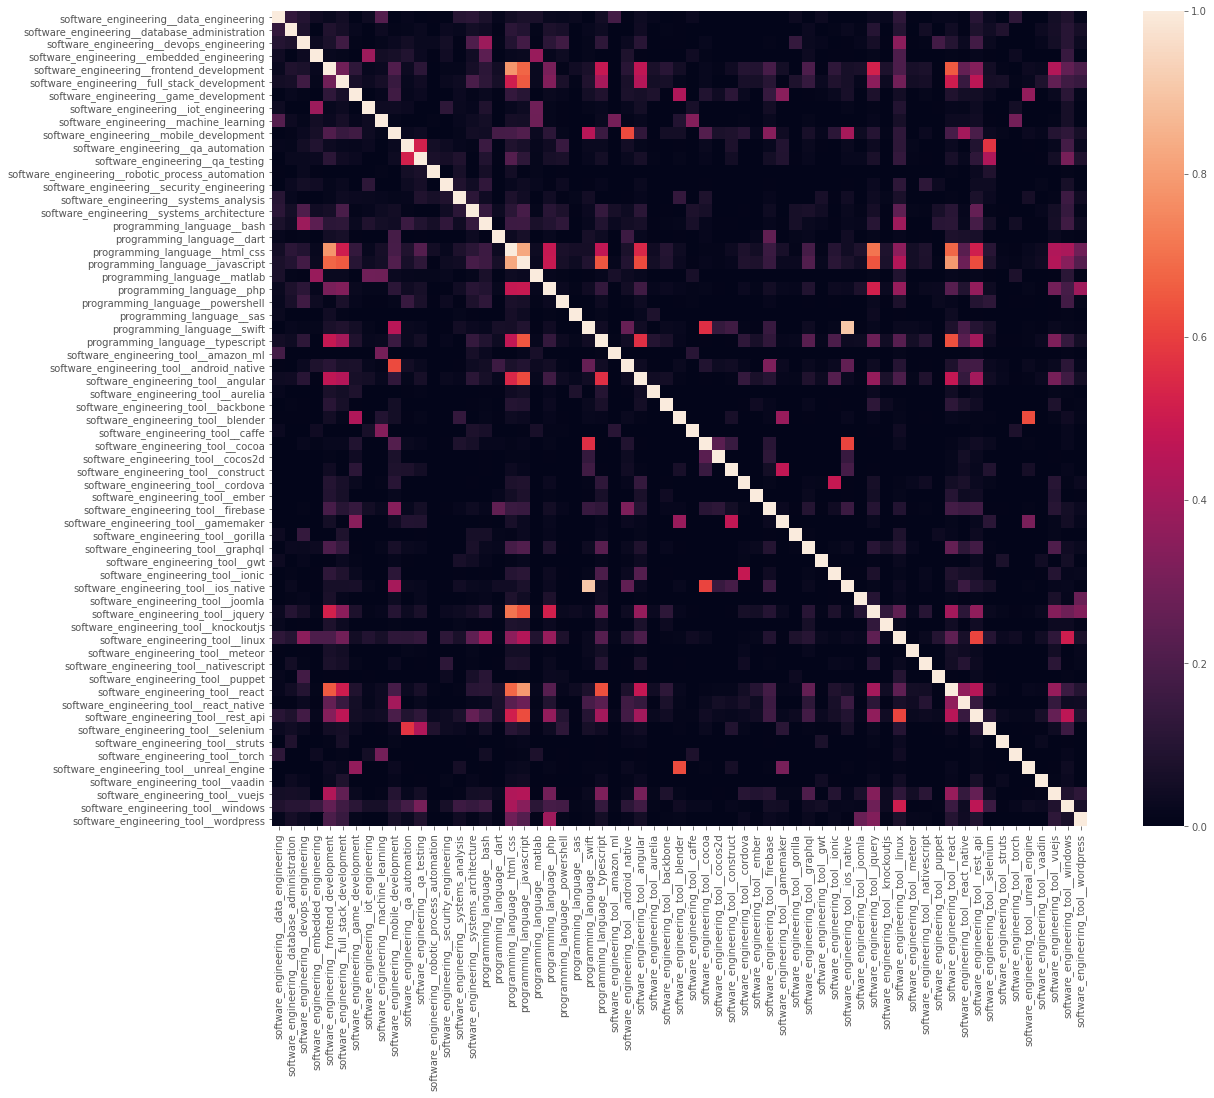

In [36]:
# df_for_tfidf_be = df_for_tfidf.loc[(df_for_tfidf['software_engineering__backend_development'] > 0) & (df_for_tfidf['software_engineering__full_stack_development'] == 0) & (df_for_tfidf['software_engineering__frontend_development'] == 0)] 
# df_for_tfidf_be[fe_skill_names] = df_for_tfidf_be[fe_skill_names] * 0.3

# df_for_tfidf_fe = df_for_tfidf.loc[(df_for_tfidf['software_engineering__frontend_development'] > 0) & (df_for_tfidf['software_engineering__full_stack_development'] == 0) & (df_for_tfidf['software_engineering__backend_development'] == 0)] 
# df_for_tfidf_fe[be_skill_names] = df_for_tfidf_be[be_skill_names] * 0.3

df_for_tfidf_fe = df_for_tfidf.copy()
df_for_tfidf_fe.drop(columns = list_filter(be_skill_names, fe_skill_names), inplace=True)
# df_for_tfidf_fe.loc[:,be_skill_names] = (df_for_tfidf_fe.loc[:,be_skill_names] / 100).astype(int)

tf_idf_fe = get_tf_idf(df_for_tfidf_fe)

df_skills_similarities_fe = pd.DataFrame(cosine_similarity(tf_idf_fe.T))
df_skills_similarities_fe.columns = df_for_tfidf_fe.columns
df_skills_similarities_fe.set_index(df_for_tfidf_fe.columns, inplace=True)
f, ax = plt.subplots( figsize=(20,15))
sns.heatmap(df_skills_similarities_fe, annot_kws={'size':20}, square=True, ax=ax)
plt.savefig(BACKUP_PATH + TF_IDF_KEY + '.1600.clust.skills.fe.png')
plt.show()


df_for_tfidf_be = df_for_tfidf.copy()
df_for_tfidf_be.drop(columns = list_filter(fe_skill_names, be_skill_names), inplace=True)
# df_for_tfidf_fe.loc[:,be_skill_names] = (df_for_tfidf_fe.loc[:,be_skill_names] / 100).astype(int)

tf_idf_be = get_tf_idf(df_for_tfidf_be)

df_skills_similarities_be = pd.DataFrame(cosine_similarity(tf_idf_be.T))
df_skills_similarities_be.columns = df_for_tfidf_be.columns
df_skills_similarities_be.set_index(df_for_tfidf_be.columns, inplace=True)
f, ax = plt.subplots( figsize=(20,15))
sns.heatmap(df_skills_similarities_be, annot_kws={'size':20}, square=True, ax=ax)
plt.savefig(BACKUP_PATH + TF_IDF_KEY + '.1600.clust.skills.be.png')
plt.show()

In [37]:
# BE
print('\nBE')
reccomend_skills(['programming_language__c_cpp',], df_skills_similarities_be, n=15)
reccomend_skills(['programming_language__java',], df_skills_similarities_be, n=15)
reccomend_skills(['programming_language__php',], df_skills_similarities_be, n=15)


# FE
print('\nFE')
reccomend_skills(['software_engineering_tool__angular',],df_skills_similarities_fe, n=15)
reccomend_skills(['software_engineering_tool__react',],df_skills_similarities_fe, n=15)
reccomend_skills(['software_engineering_tool__jquery',],df_skills_similarities_fe, n=15)


print('\nBE vs FE')
reccomend_skills(['programming_language__javascript',],df_skills_similarities_be, n=15)
reccomend_skills(['programming_language__javascript',],df_skills_similarities_fe, n=15)
# reccomend_skills(['programming_language__java',],df_skills_similarities_fe, n=15)
# reccomend_skills(['programming_language__csharp',],df_skills_similarities_fe, n=15)
# reccomend_skills(['software_engineering__backend_development', 'programming_language__javascript',],df_skills_similarities_fe, n=10)


BE
Recomendations for: ['programming_language__c_cpp']


skill     score
1   software_engineering__embedded_engineering  0.607776
2                software_engineering_tool__qt  0.427302
3             software_engineering_tool__linux  0.402133
4                 programming_language__python  0.396069
5           software_engineering_tool__windows  0.362412
6                 programming_language__matlab  0.314870
7        software_engineering__iot_engineering  0.302015
8    software_engineering__backend_development  0.299670
9                 programming_language__csharp  0.279492
10                  programming_language__java  0.257764
11                   programming_language__sql  0.225846
12                  programming_language__bash  0.171918
13   software_engineering_tool__android_native  0.169098
14            software_engineering_tool__unity  0.163912

Recomendations for: ['programming_language__java']


skill     score
1              software_engineering_tool__spring  0.838773
2      software_engineering__backend_development  0.625817
3           software_engineering_tool__hibernate  0.618573
4                      programming_language__sql  0.602163
5            software_engineering_tool__rest_api  0.568440
6          software_engineering_tool__postgresql  0.514690
7               software_engineering_tool__linux  0.467302
8              software_engineering_tool__docker  0.449548
9   software_engineering__full_stack_development  0.423695
10     software_engineering_tool__android_native  0.403056
11                  programming_language__kotlin  0.387978
12              programming_language__javascript  0.380223
13              software_engineering_tool__mysql  0.374850
14            software_engineering_tool__jenkins  0.362127

Recomendations for: ['programming_language__php']


skill     score
1               software_engineering_tool__mysql  0.743426
2             software_engineering_tool__laravel  0.659452
3               programming_language__javascript  0.518896
4             software_engineering_tool__symfony  0.479606
5           software_engineering_tool__wordpress  0.440320
6                      programming_language__sql  0.436292
7            software_engineering_tool__rest_api  0.430385
8      software_engineering__backend_development  0.430158
9               software_engineering_tool__linux  0.390831
10  software_engineering__full_stack_development  0.388906
11             software_engineering_tool__docker  0.269234
12             software_engineering_tool__nodejs  0.258726
13            software_engineering_tool__windows  0.244350
14       software_engineering_tool__code_igniter  0.237959


FE
Recomendations for: ['software_engineering_tool__angular']


skill     score
1               programming_language__javascript  0.622954
2               programming_language__typescript  0.565984
3                 programming_language__html_css  0.542710
4               software_engineering_tool__react  0.483624
5     software_engineering__frontend_development  0.471779
6   software_engineering__full_stack_development  0.444181
7            software_engineering_tool__rest_api  0.403008
8              software_engineering_tool__jquery  0.372383
9               software_engineering_tool__vuejs  0.297586
10              software_engineering_tool__ionic  0.220853
11              software_engineering_tool__linux  0.198752
12            software_engineering_tool__windows  0.167811
13                     programming_language__php  0.165394
14            software_engineering_tool__cordova  0.138613

Recomendations for: ['software_engineering_tool__react']


skill     score
1               programming_language__javascript  0.792576
2                 programming_language__html_css  0.682193
3     software_engineering__frontend_development  0.652945
4               programming_language__typescript  0.634175
5   software_engineering__full_stack_development  0.504403
6             software_engineering_tool__angular  0.483624
7            software_engineering_tool__rest_api  0.452757
8              software_engineering_tool__jquery  0.408880
9               software_engineering_tool__vuejs  0.376061
10       software_engineering_tool__react_native  0.362721
11            software_engineering_tool__graphql  0.255448
12              software_engineering_tool__linux  0.243553
13                     programming_language__php  0.225189
14      software_engineering__mobile_development  0.186795

Recomendations for: ['software_engineering_tool__jquery']


skill     score
1                 programming_language__html_css  0.707615
2               programming_language__javascript  0.644471
3     software_engineering__frontend_development  0.521629
4                      programming_language__php  0.517729
5               software_engineering_tool__react  0.408880
6             software_engineering_tool__angular  0.372383
7            software_engineering_tool__rest_api  0.361615
8   software_engineering__full_stack_development  0.353819
9               software_engineering_tool__vuejs  0.332435
10          software_engineering_tool__wordpress  0.325146
11            software_engineering_tool__windows  0.279516
12              programming_language__typescript  0.275566
13              software_engineering_tool__linux  0.243947
14         software_engineering_tool__knockoutjs  0.130135


BE vs FE
Recomendations for: ['programming_language__javascript']


skill     score
1              software_engineering_tool__nodejs  0.756138
2            software_engineering_tool__rest_api  0.750656
3               programming_language__typescript  0.632177
4   software_engineering__full_stack_development  0.580007
5                      programming_language__php  0.518896
6               software_engineering_tool__mysql  0.518267
7                      programming_language__sql  0.496021
8      software_engineering__backend_development  0.469990
9               software_engineering_tool__linux  0.445993
10            software_engineering_tool__windows  0.396680
11             software_engineering_tool__docker  0.389286
12                    programming_language__java  0.380223
13            software_engineering_tool__express  0.344071
14         software_engineering_tool__postgresql  0.325553

Recomendations for: ['programming_language__javascript']


skill     score
1                 programming_language__html_css  0.827408
2               software_engineering_tool__react  0.792576
3     software_engineering__frontend_development  0.676361
4   software_engineering__full_stack_development  0.654733
5               programming_language__typescript  0.646392
6              software_engineering_tool__jquery  0.644471
7            software_engineering_tool__rest_api  0.625107
8             software_engineering_tool__angular  0.622954
9                      programming_language__php  0.491631
10              software_engineering_tool__linux  0.444939
11              software_engineering_tool__vuejs  0.441406
12            software_engineering_tool__windows  0.342721
13       software_engineering_tool__react_native  0.275915
14          software_engineering_tool__wordpress  0.219412